<h1 style="text-align:center;font-size:30px;" > Quora Question Pairs </h1>

<h1> 1. Business Problem </h1>

<h2> 1.1 Description </h2>

<p>Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.</p>
<p>
Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
</p>
<br>
> Credits: Kaggle 

**_Problem Statement_**
- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 

<h2>1.2 Real world/Business Objectives and Constraints </h2>

1. The cost of a mis-classification can be very high.
2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretability is partially important.

<h1>2. Machine Learning Problem </h1>

<h2> 2.1 Data </h2>

<h3> 2.1.1 Data Overview </h3>

<p> 
- Data will be in a file Train.csv <br>
- Train.csv contains 6 columns : id, qid1, qid2, question1, question2, is_duplicate <br>
- Size of Train.csv - 60MB <br>
- Number of rows in Train.csv = 404,290
</p>

<h3> 2.1.2 Example Data point </h3>

<pre>
"id","qid1","qid2","question1","question2","is_duplicate"
"0","1","2","What is the step by step guide to invest in share market in india?","What is the step by step guide to invest in share market?","0"
"1","3","4","What is the story of Kohinoor (Koh-i-Noor) Diamond?","What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?","0"
"7","15","16","How can I be a good geologist?","What should I do to be a great geologist?","1"
"11","23","24","How do I read and find my YouTube comments?","How can I see all my Youtube comments?","1"
</pre>

<h2> 2.2 Mapping the real world problem to an ML problem </h2>

<h3> 2.2.1 Type of Machine Learning Problem </h3>

<p> It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not. </p>

<h3> 2.2.2 Performance Metric </h3>

Source: https://www.kaggle.com/c/quora-question-pairs#evaluation

Metric(s): 
* log-loss : https://www.kaggle.com/wiki/LogarithmicLoss
* Binary Confusion Matrix

<h2> 2.3 Train and Test Construction </h2>

<p> We build train and test by randomly splitting in the ratio of 70:30 or 80:20 whatever we choose as we have sufficient points to work with. </p>

<h1>3. Exploratory Data Analysis </h1>

In [56]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-dark-palette')
%config InlineBackend.figure_format = 'retina'

import re
import nltk
import os
nltk.download('stopwords')
import string
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image
from tqdm import tqdm
from scipy.sparse import hstack

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import spacy

from sklearn.metrics import precision_recall_curve, auc, roc_curve, confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss

# Model imports
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from xgboost.sklearn import XGBClassifier

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/rushabh6792/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<h2> 3.1 Reading data and basic stats </h2>

In [2]:
df = pd.read_csv('./Dataset/train.csv')
print("Number of data points: ", df.shape[0])

Number of data points:  404290


In [3]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [5]:
df.describe()

,id,qid1,qid2,is_duplicate
count,404290.000000,404290.000000,404290.000000,404290.000000
mean,202144.500000,217243.942418,220955.655337,0.369198
std,116708.614503,157751.700002,159903.182629,0.482588
min,0.000000,1.000000,2.000000,0.000000
25%,101072.250000,74437.500000,74727.000000,0.000000
50%,202144.500000,192182.000000,197052.000000,0.000000
75%,303216.750000,346573.500000,354692.500000,1.000000
max,404289.000000,537932.000000,537933.000000,1.000000


We are given a minimal number of data fields here, consisting of:

- id:  Looks like a simple rowID
- qid{1, 2}:  The unique ID of each question in the pair
- question{1, 2}:  The actual textual contents of the questions.
- is_duplicate:  The label that we are trying to predict - whether the two questions are duplicates of each other.

By looking at the info of the dataset - 

We are able to see that there are 2 null/NaN values in Question2 and 1 null/NaN value in Question1. We have to handle this in feature engineering.

<h3> 3.2.1 Distribution of data points among output classes</h3>
- Number of duplicate(similar) and non-duplicate(non similar) questions

In [6]:
df['is_duplicate'].value_counts(normalize=True) * 100

0    63.080215
1    36.919785
Name: is_duplicate, dtype: float64

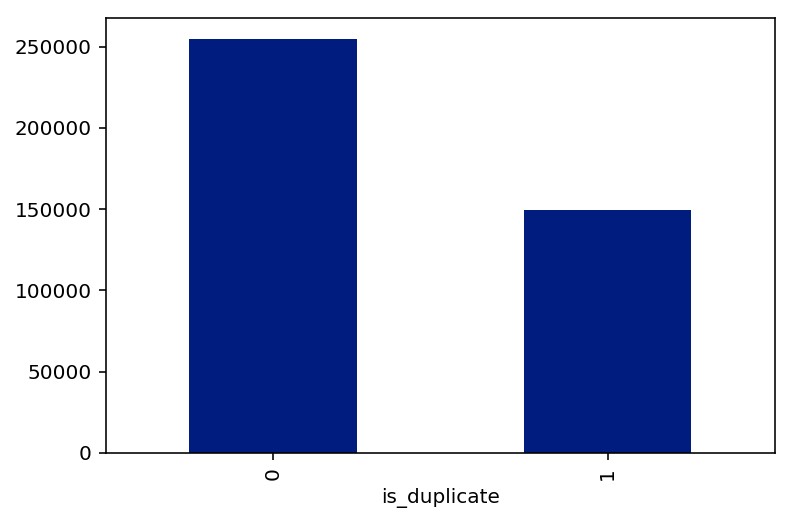

In [7]:
df.groupby('is_duplicate')['id'].count().plot.bar()

In [8]:
print("Total number of Question pairs for Training: ", len(df))

Total number of Question pairs for Training:  404290


In [9]:
print(" ~ Question pairs are NOT similar (is_duplicate = 0) : {}%".format(
    100 - round(df['is_duplicate'].mean() * 100, 2)))
print(" ~ Question pairs are similar     (is_duplicate = 1) : {}%".format(
    round(df['is_duplicate'].mean() * 100, 2)))

 ~ Question pairs are NOT similar (is_duplicate = 0) : 63.08%
 ~ Question pairs are similar     (is_duplicate = 1) : 36.92%


<h3> 3.2.2 Number of unique questions </h3>

In [10]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qids = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)

print(" ~ Total number of Unique Questions: ", unique_qids)

print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qids*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

 ~ Total number of Unique Questions:  537933
Number of unique questions that appear more than one time: 111780 (20.77953945937505%)

Max number of times a single question is repeated: 157



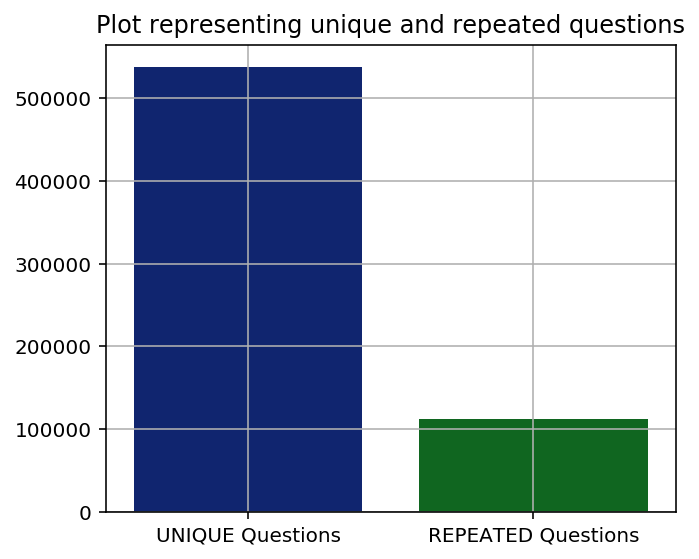

In [11]:
q_values = qids.value_counts().values
x = ["UNIQUE Questions", "REPEATED Questions"]
y = [unique_qids, qs_morethan_onetime]


plt.figure(figsize=(5, 4))
plt.title("Plot representing unique and repeated questions")
sns.barplot(x, y)
plt.tight_layout()
plt.grid()
plt.show()

<h3>3.2.3 Checking for Duplicates </h3>

In [12]:
duplicate_questions = df[['qid1', 'qid2', 'is_duplicate']].groupby(['qid1', 'qid2']).count().reset_index()

print(" ~ Number of duplicate questions: ", duplicate_questions.shape[0] - df.shape[0])

 ~ Number of duplicate questions:  0


<h3> 3.2.4 Number of occurrences of each question </h3>

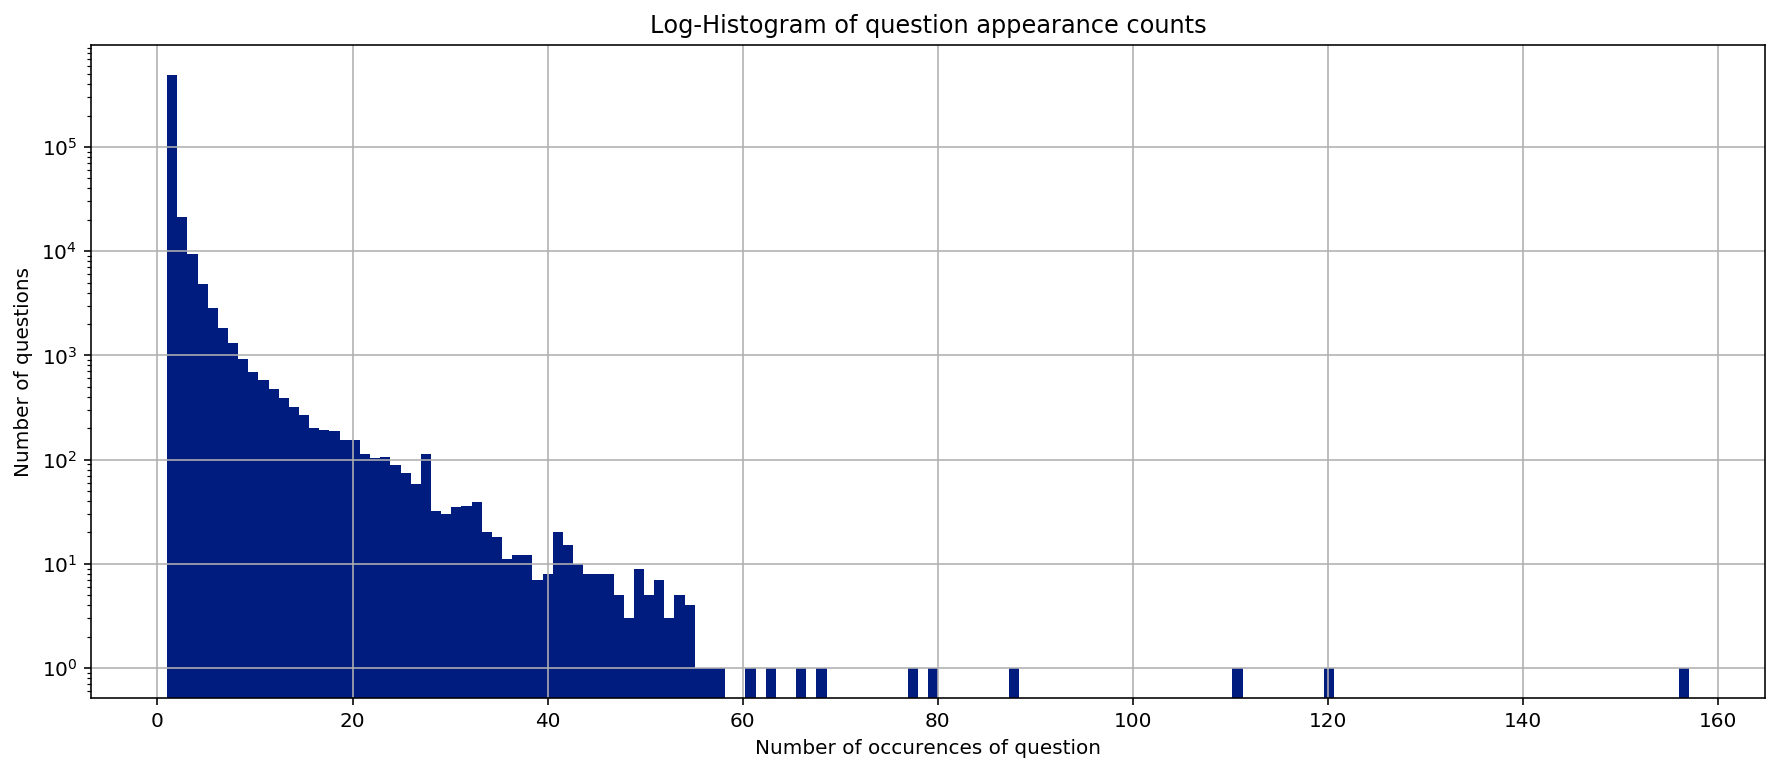

In [13]:
plt.figure(figsize=(15, 6))

plt.hist(qids.value_counts(), bins=150)

plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')

plt.grid()
plt.show()

In [14]:
print(" ~ Maximum number of time a question occured: ", max(qids.value_counts()))

print(" ~ Question which occurred most number of time ->> ", df[df['qid1'] == qids.value_counts().index[0]]['question1'].iloc[0])

 ~ Maximum number of time a question occured:  157
 ~ Question which occurred most number of time ->>  What are the best ways to lose weight?


<h3> 3.2.5 Checking for NULL values </h3>

In [15]:
#Checking whether there are any rows with null values
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


**Observation**

1. There is 1 NaN/null value in question 1 column.
2. There are 2 NaN/null values in question 2 column.

In [16]:
# Filling the null values with ' '
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


<h2>3.3 Basic Feature Extraction (before cleaning) </h2>

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2
 - ____No_Questions_q1____ = Total number of questions in qid1
 - ____No_Questions_q2____ = Total number of questions in qid2
 - ____q1_q2_difference____ = Number of words which are in Question 1 but no in Question 2
 - ____q2_q1_difference____ = Number of words which are in Question 2 but no in Question 1
 - ____diff_len____ = Difference in absolute value of the Length of q1 and q2

In [17]:
df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 
df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
df['q1len'] = df['question1'].str.len() 
df['q2len'] = df['question2'].str.len()
df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

def normalized_word_Common(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)
df['word_Common'] = df.apply(normalized_word_Common, axis=1)

def normalized_word_Total(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * (len(w1) + len(w2))
df['word_Total'] = df.apply(normalized_word_Total, axis=1)

def normalized_word_share(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
df['word_share'] = df.apply(normalized_word_share, axis=1)

def normalized_word_difference_1(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1.difference(w2))
df['q1_q2_difference'] = df.apply(normalized_word_difference_1, axis=1)

def normalized_word_difference_2(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w2.difference(w1))
df['q2_q1_difference'] = df.apply(normalized_word_difference_2, axis=1)

df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

df['No_Questions_q1'] = df['question1'].apply(lambda row: str(row).count('?'))
df['No_Questions_q2'] = df['question2'].apply(lambda row: str(row).count('?'))

df['diff_len'] = abs(df.q1len - df.q2len)

In [18]:
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,word_Common,word_Total,word_share,q1_q2_difference,q2_q1_difference,freq_q1+q2,freq_q1-q2,No_Questions_q1,No_Questions_q2,diff_len
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,...,10.0,23.0,0.434783,2.0,1.0,2,0,1,1,9
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,...,4.0,20.0,0.200000,4.0,8.0,5,3,1,1,37


<h3> 3.3.1 Analysis of some of the extracted features </h3>

- Here are some questions have only one single words.

In [19]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 67
Number of Questions with minimum length [question2] : 24


<h4> 3.3.1.1 Feature: word_share </h4>

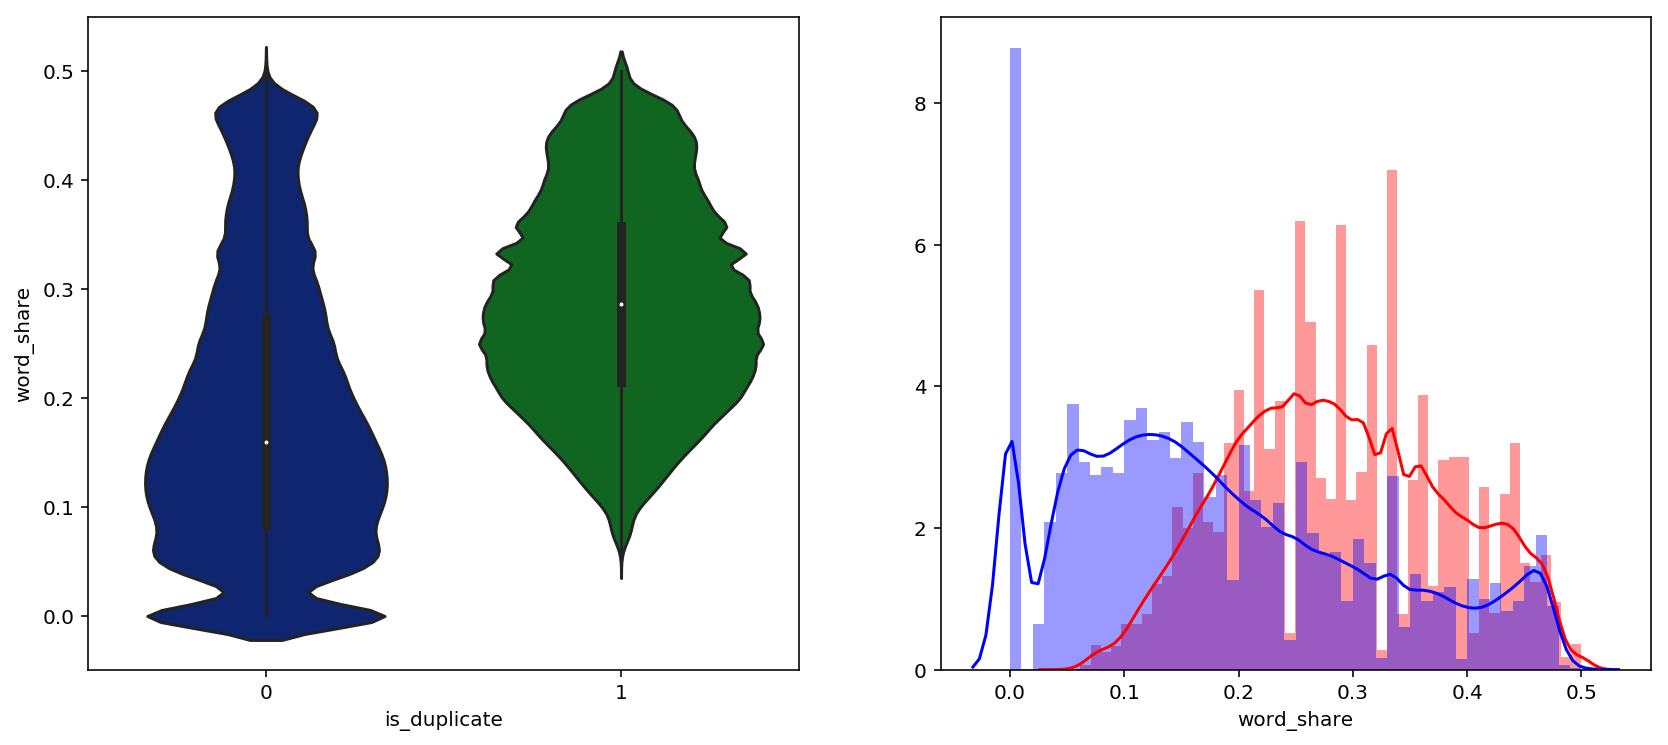

In [20]:
plt.figure(figsize=(14, 6))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

- The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity
- The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)

<h4> 3.3.1.2 Feature: word_Common </h4>

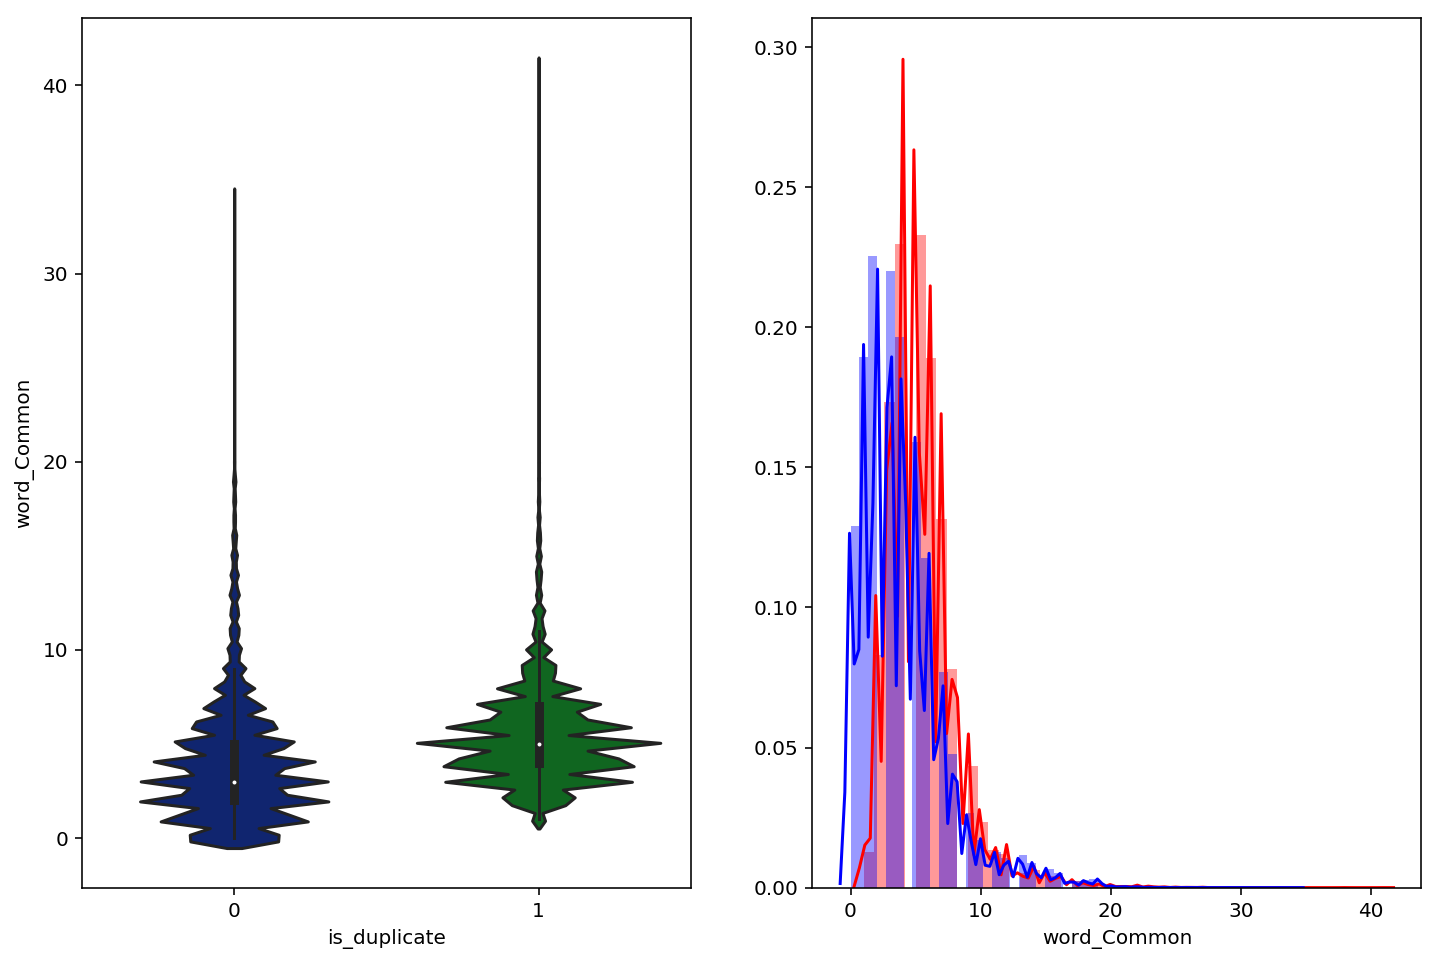

In [21]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

<p> The distributions of the word_Common feature in similar and non-similar questions are highly overlapping </p>

<h4> 3.3.1.3 Feature: No_Questions_q1 & No_Questions_q2 </h4>

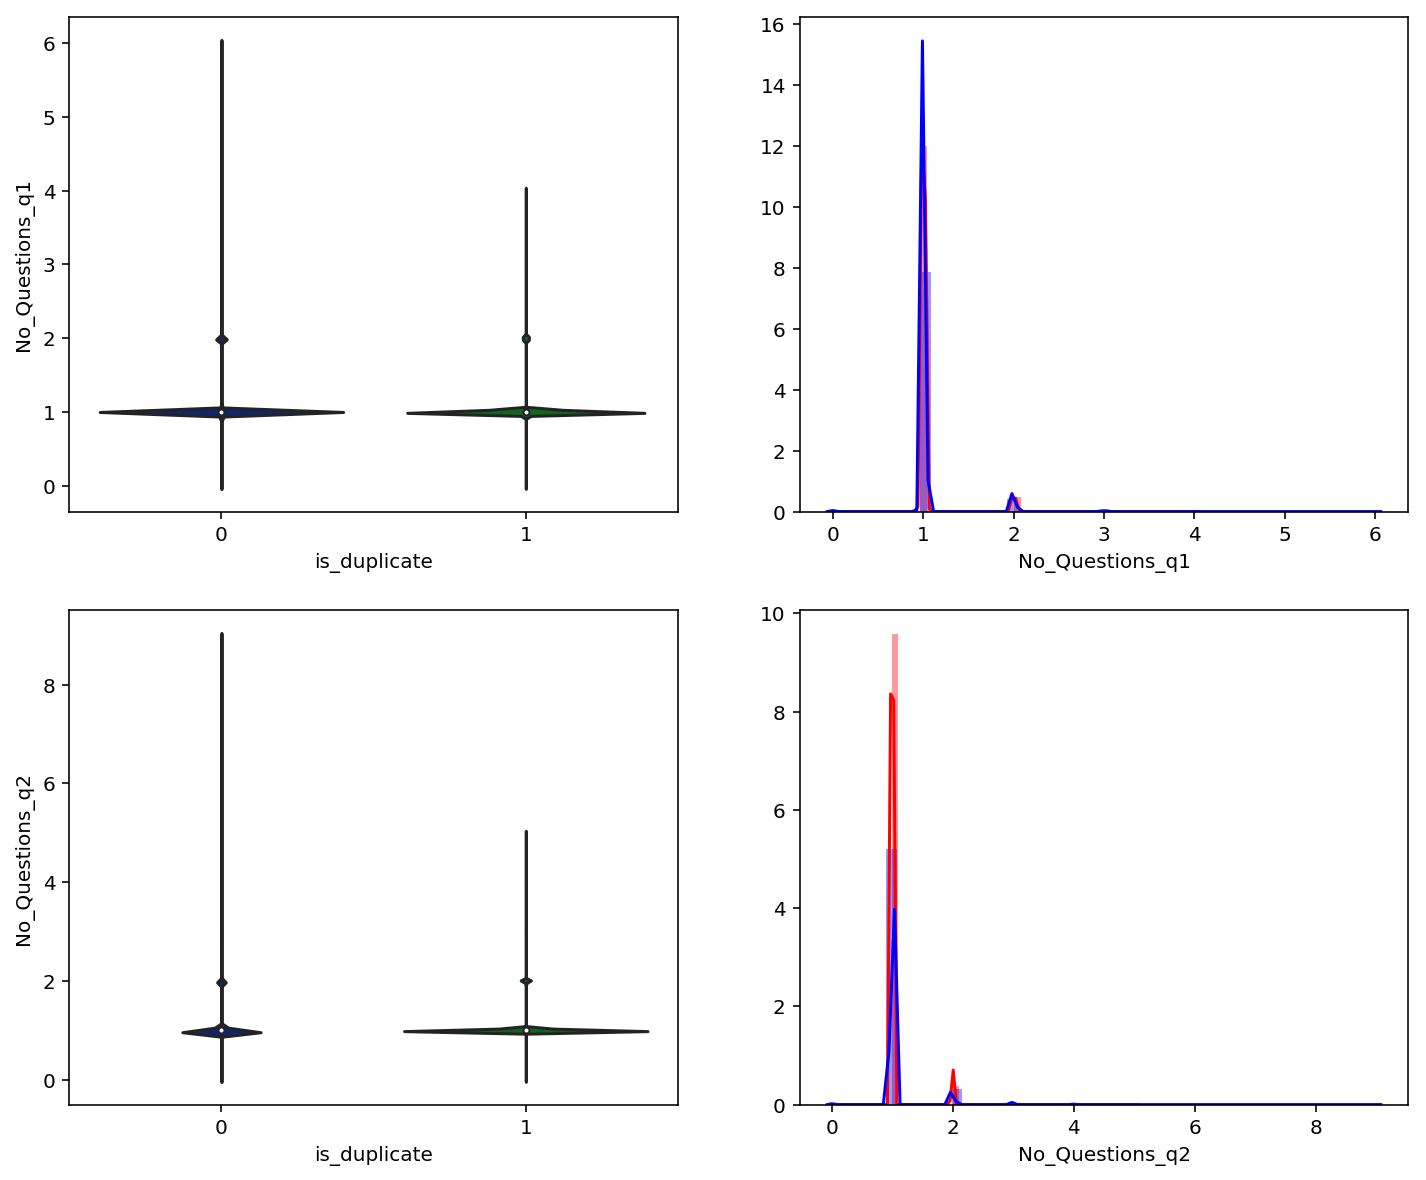

In [22]:
plt.figure(figsize=(12, 10))


plt.subplot(2,2,1)
sns.violinplot(x = 'is_duplicate', y = 'No_Questions_q1', data = df[0:])

plt.subplot(2,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['No_Questions_q1'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['No_Questions_q1'][0:] , label = "0" , color = 'blue' )

plt.subplot(2,2,3)
sns.violinplot(x = 'is_duplicate', y = 'No_Questions_q2', data = df[0:])

plt.subplot(2,2,4)
sns.distplot(df[df['is_duplicate'] == 1.0]['No_Questions_q2'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['No_Questions_q2'][0:] , label = "0" , color = 'blue' )
plt.show()

<p> The distributions of the No_Questions_q1 and No_Questions_q2 feature in similar and non-similar questions are highly overlapping </p>

<h4> 3.3.1.4 Feature: q1_q2_intersect </h4>

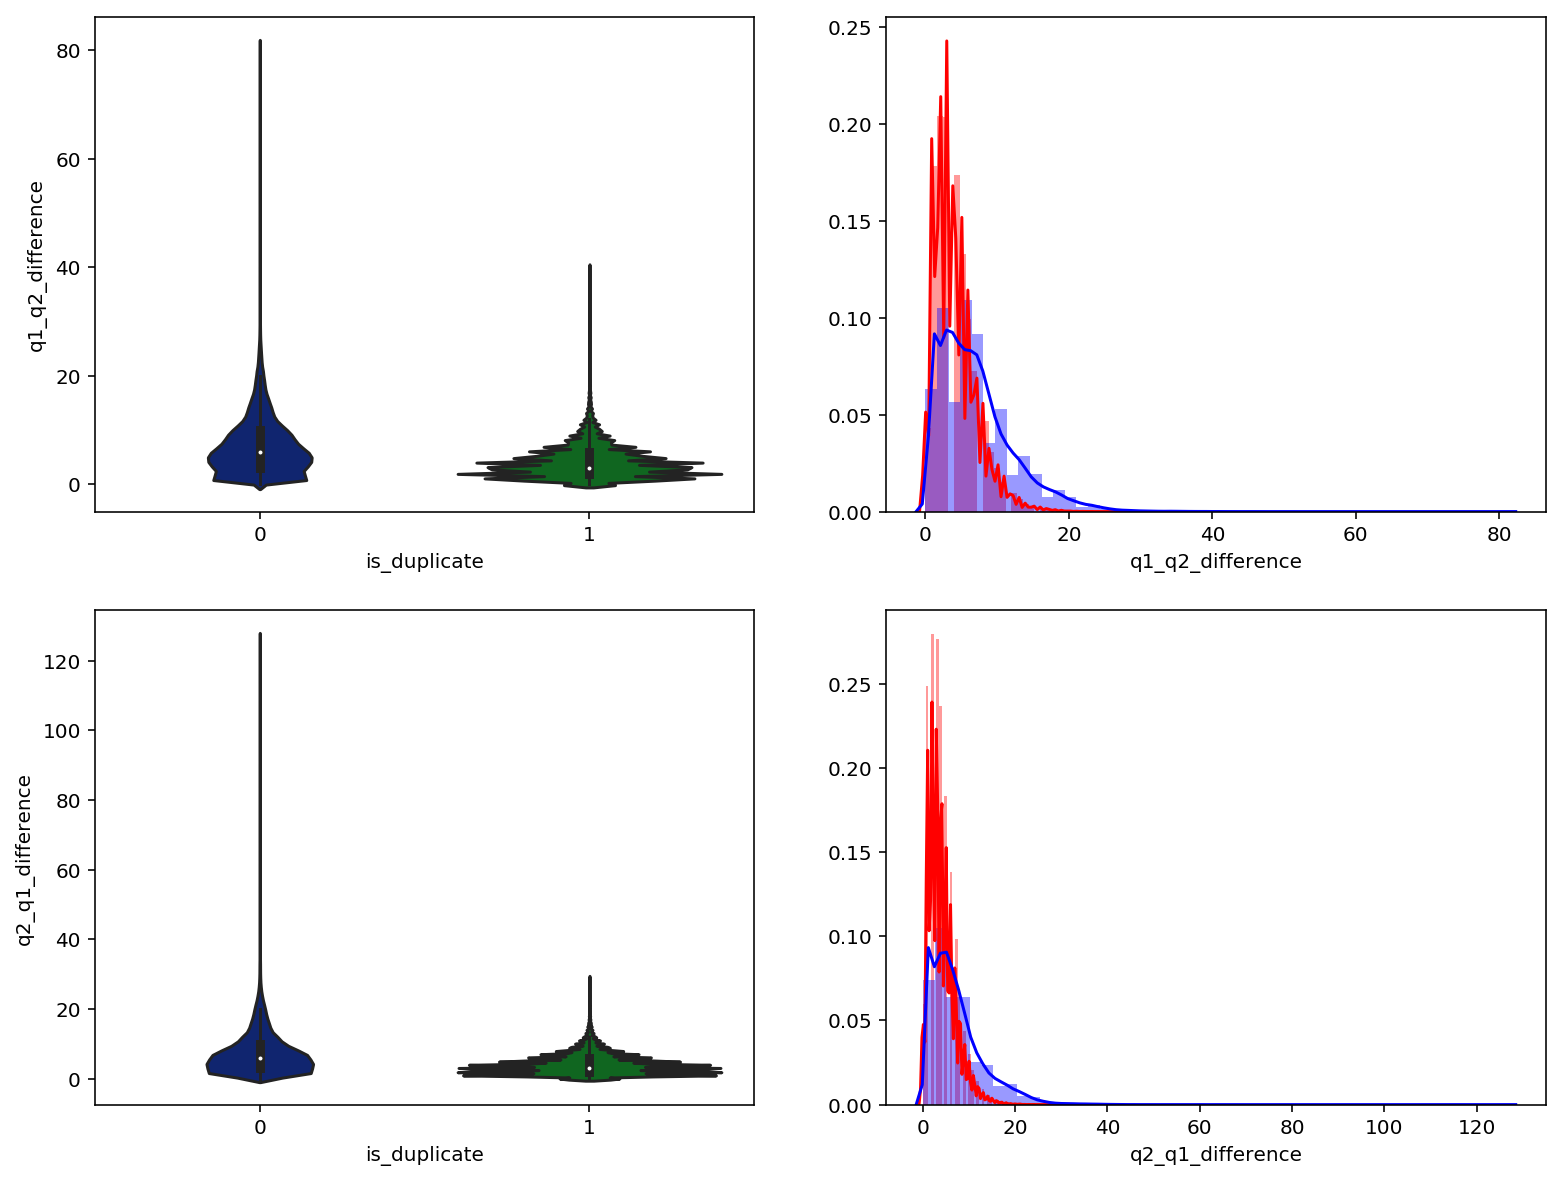

In [23]:
plt.figure(figsize=(13, 10))


plt.subplot(2,2,1)
sns.violinplot(x = 'is_duplicate', y = 'q1_q2_difference', data = df[0:])

plt.subplot(2,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['q1_q2_difference'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['q1_q2_difference'][0:] , label = "0" , color = 'blue' )

plt.subplot(2,2,3)
sns.violinplot(x = 'is_duplicate', y = 'q2_q1_difference', data = df[0:])

plt.subplot(2,2,4)
sns.distplot(df[df['is_duplicate'] == 1.0]['q2_q1_difference'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['q2_q1_difference'][0:] , label = "0" , color = 'blue' )
plt.show()

<p> The distributions of the q1_q2_intersect feature in similar and non-similar questions are highly overlapping </p>

<h4> 3.3.1.5 Feature: diff_len </h4>

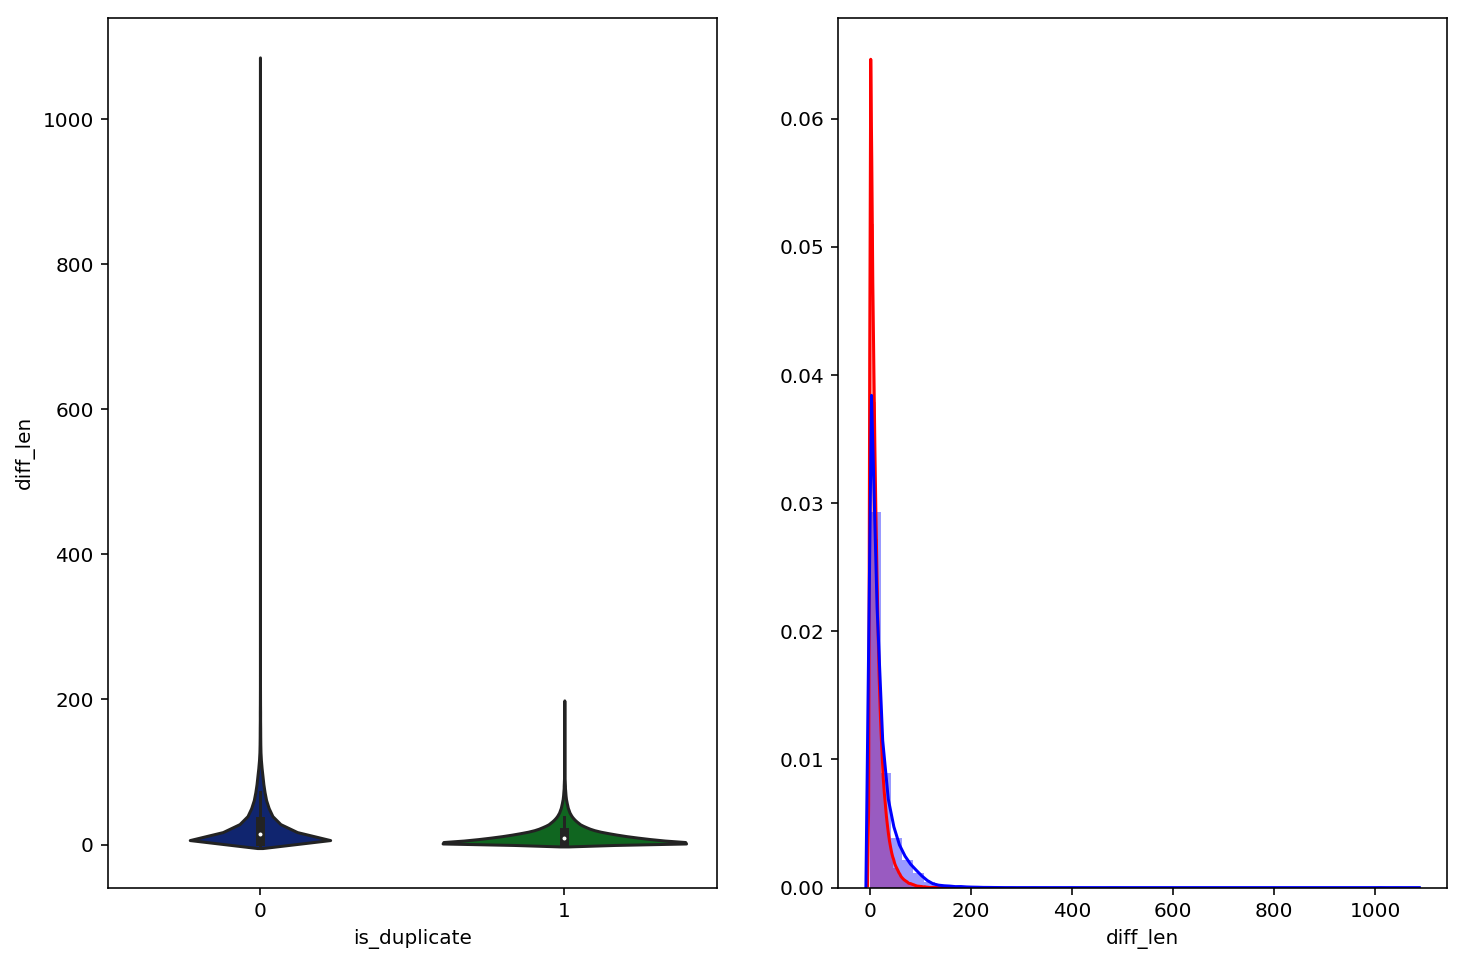

In [24]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'diff_len', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['diff_len'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['diff_len'][0:] , label = "0" , color = 'blue' )
plt.show()

<p> The distributions of the diff_len feature in similar and non-similar questions are highly overlapping </p>

<h2> 3.4 Preprocessing of Text </h2>

- Preprocessing:
    - Removing html tags 
    - Removing Punctuations
    - Performing stemming
    - Removing Stopwords
    - Expanding contractions etc.

In [25]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x

- Function to Compute and get the features : With 2 parameters of Question 1 and Question 2

<h2> 3.5 Advanced Feature Extraction (NLP and Fuzzy Features) </h2>

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>



- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))



<br><p>NEW FEATURES WHICH are ADDED!!!</p><br>

- __nouns_share__ :  Extracting parts-of-speech using Spacy from Questions. Normalized Nouns share between Q1 and Q2
<br>
<br>

- __verb_share__ :  Extracting parts-of-speech using Spacy from Questions. Normalized Verbs share between Q1 and Q2
<br>
<br>

- __entity_category_share__ :  Extracting parts-of-speech using Spacy from Questions. Normalized Entity Categorization share between Q1 and Q2
<br>
<br>

In [26]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')

def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    
    def returnNormalizedResult(s1, s2):
        if (len(s1) + len(s2)) == 0:
            return 0
        return 1.0 * len(s1 & s2)/(len(s1) + len(s2))
    
    def normalized_semantic_share(row):
        q1 = str(row['question1'])
        q2 = str(row['question2'])
        
        doc1 = nlp(q1)
        doc2 = nlp(q2)
        
        nouns1 = set(list([chunk.text for chunk in doc1.noun_chunks]))
        verbs1 = set(list([token.lemma_ for token in doc1 if token.pos_ == "VERB"]))
        entities1 = set(list([entity.label_ for entity in doc1.ents]))
        
        nouns2 = set(list([chunk.text for chunk in doc2.noun_chunks]))
        verbs2 = set(list([token.lemma_ for token in doc2 if token.pos_ == "VERB"]))
        entities2 = set(list([entity.label_ for entity in doc2.ents]))
        
        row['nouns_share'] = returnNormalizedResult(nouns1, nouns2)
        row['verb_share'] = returnNormalizedResult(verbs1, verbs2)
        row['entity_category_share'] = returnNormalizedResult(entities1, entities2)
        return row

    print("Spacy features...")
    df = df.apply(normalized_semantic_share, axis=1)
    
    return df

In [27]:
if os.path.isfile('df_with_preprocessing_train.csv'):
    df = pd.read_csv("df_with_preprocessing_train.csv",encoding='latin-1')
else:
    df = extract_features(df)
    df.to_csv("df_with_preprocessing_train.csv", index=False)
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,nouns_share,verb_share,entity_category_share
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,...,2.0,13.0,100,93,93,100,0.982759,0.444444,0.50,0.0
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,4,1,51,88,...,5.0,12.5,86,63,66,75,0.596154,0.222222,0.25,0.0


<h3>3.5.1 Analysis of extracted features </h3>

<h4> 3.5.1.1 Plotting Word clouds</h4>

- Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
- We can observe the most frequent occuring words

In [28]:
df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s')
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s')

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


In [29]:
# reading the text files and removing the Stop Words:
d = path.dirname('.')

textp_w = open(path.join(d, 'train_p.txt')).read()
textn_w = open(path.join(d, 'train_n.txt')).read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 16110763
Total number of words in non duplicate pair questions : 33201102


__Word Clouds generated from  duplicate pair question's text__

Word Cloud for Duplicate Question pairs


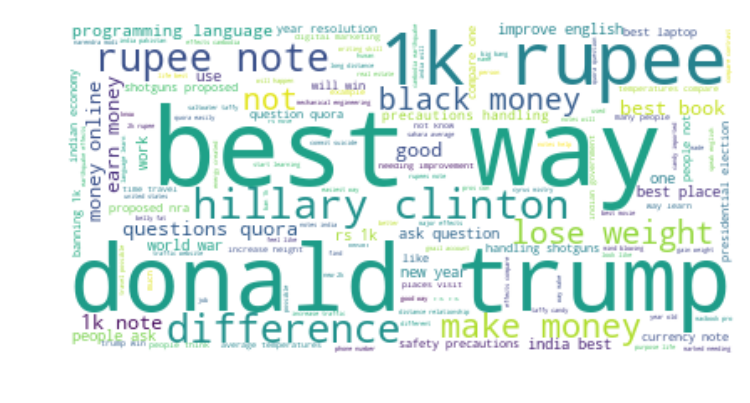

In [30]:
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

__Word Clouds generated from non duplicate pair question's text__

Word Cloud for non-Duplicate Question pairs:


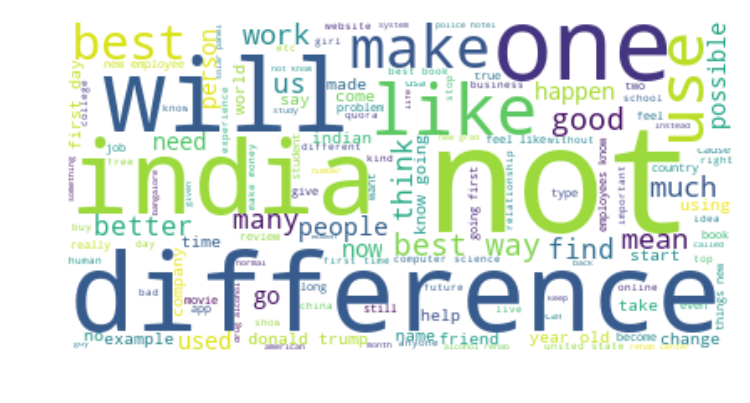

In [31]:
wc = WordCloud(background_color="white", max_words=len(textn_w),stopwords=stopwords)
# generate word cloud
wc.generate(textn_w)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

<h4> 3.5.1.2 Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'] </h4>

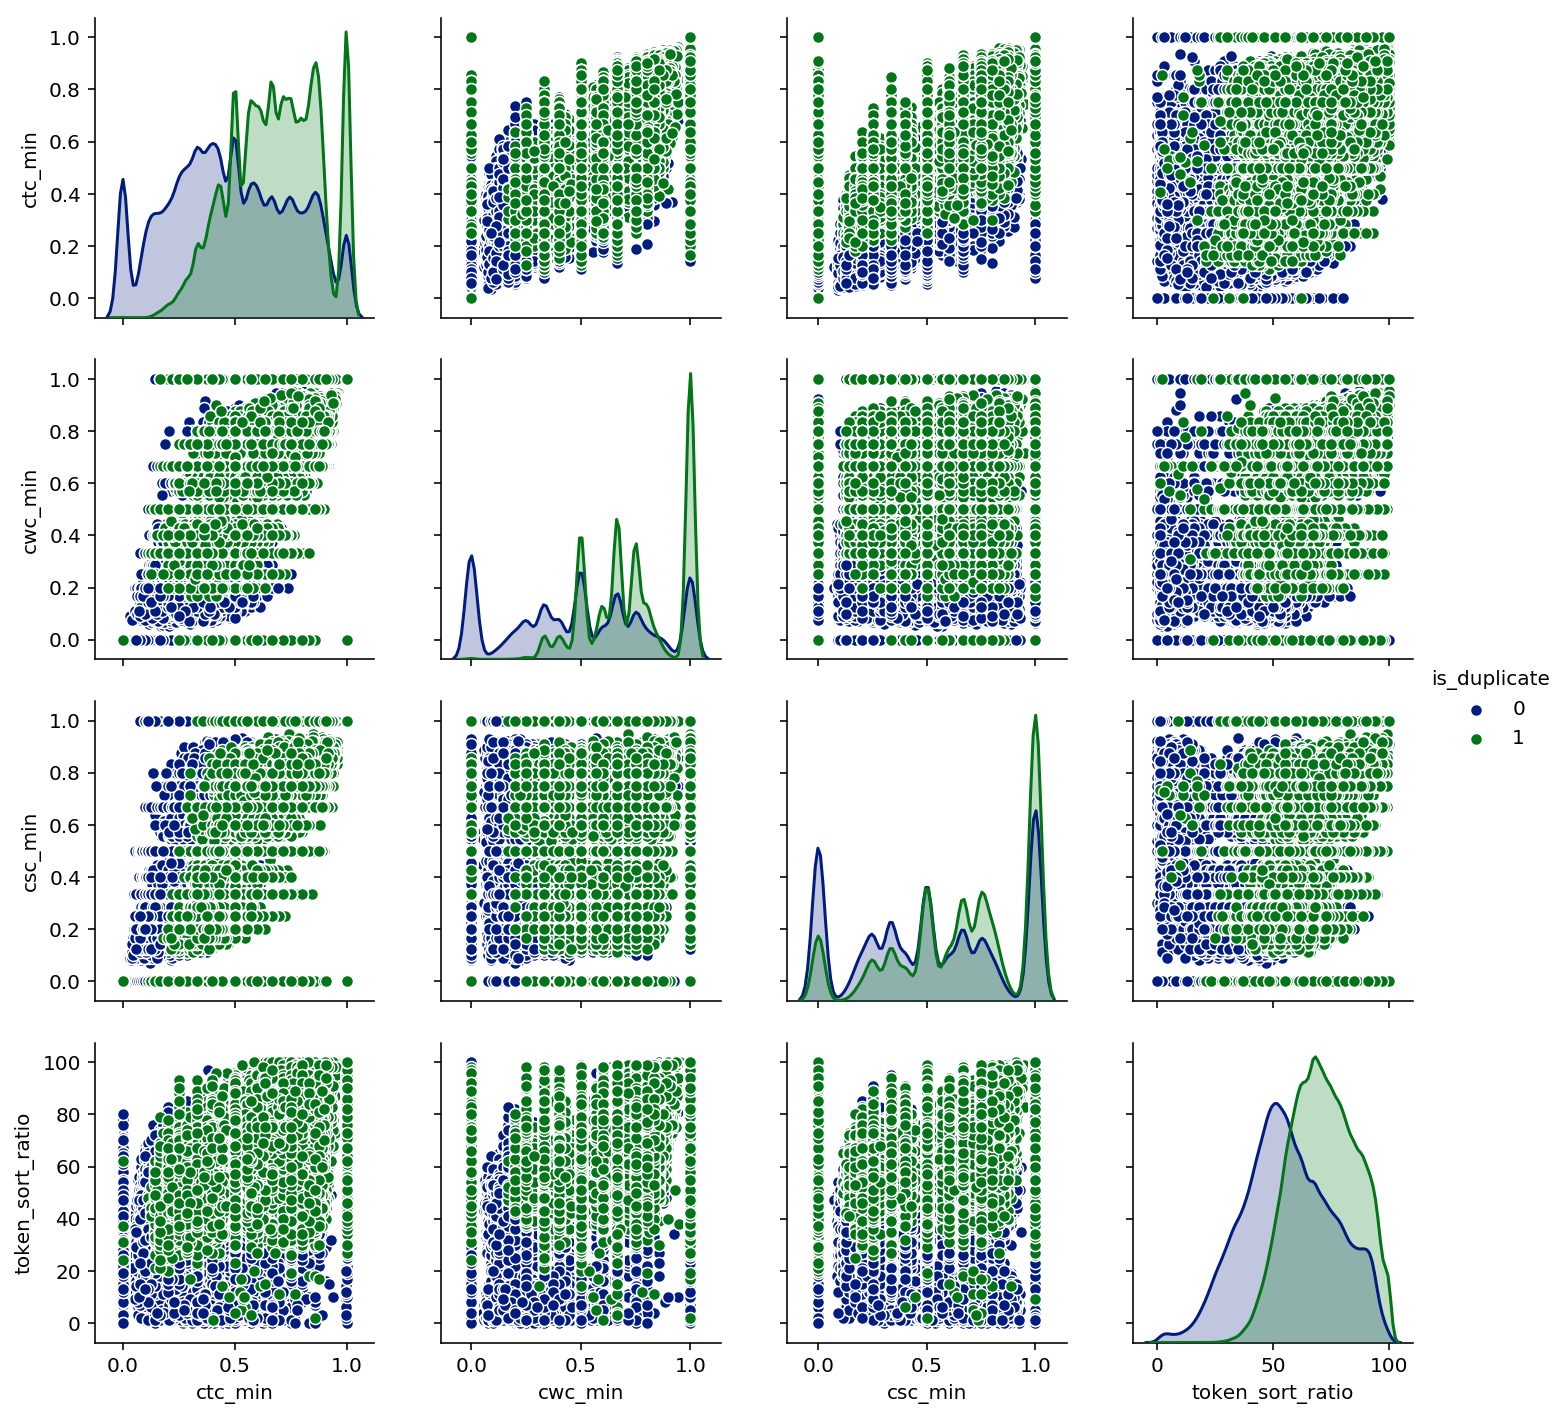

In [32]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

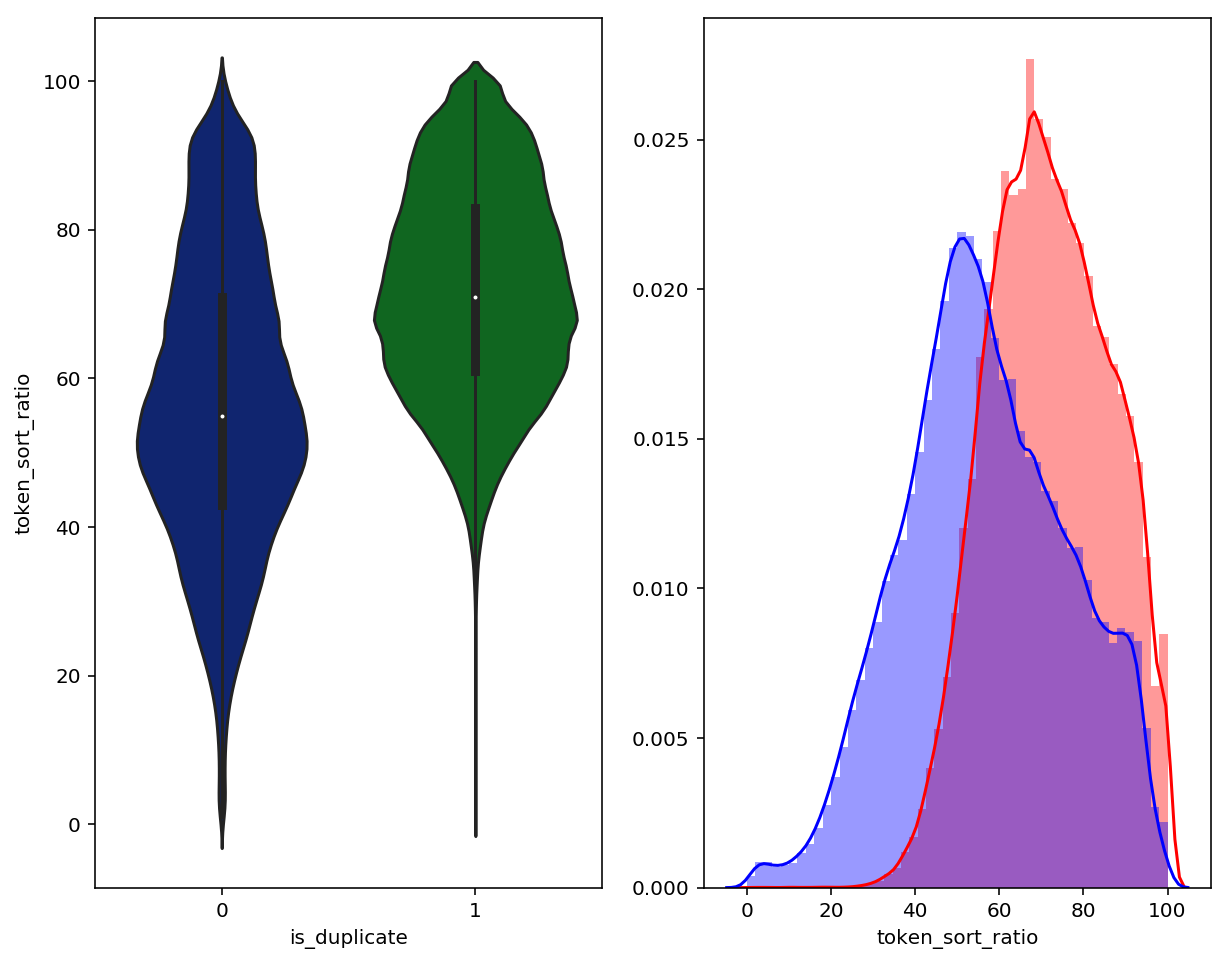

In [33]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

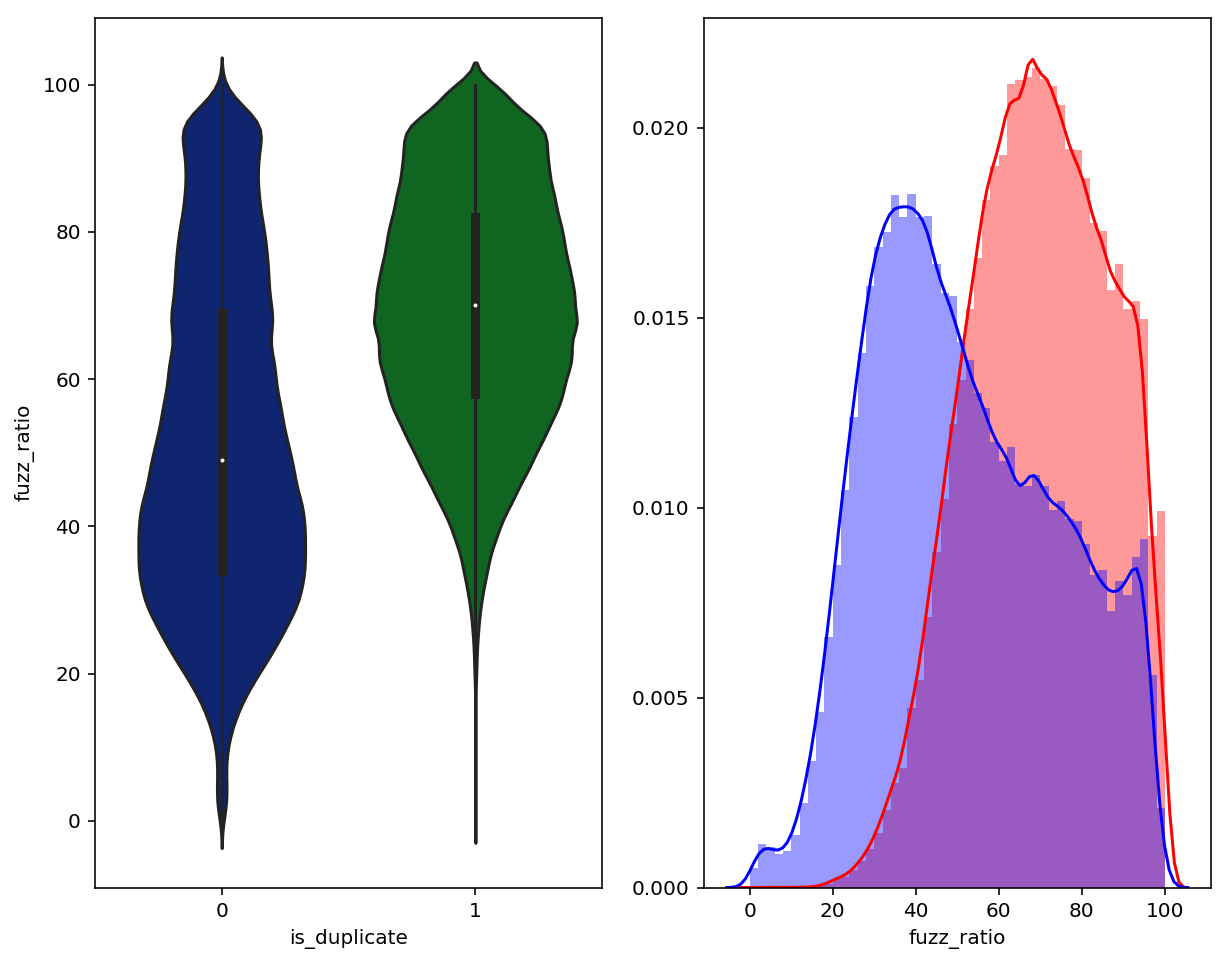

In [34]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

<h4> 3.5.1.3 Feature: nouns_share </h4>

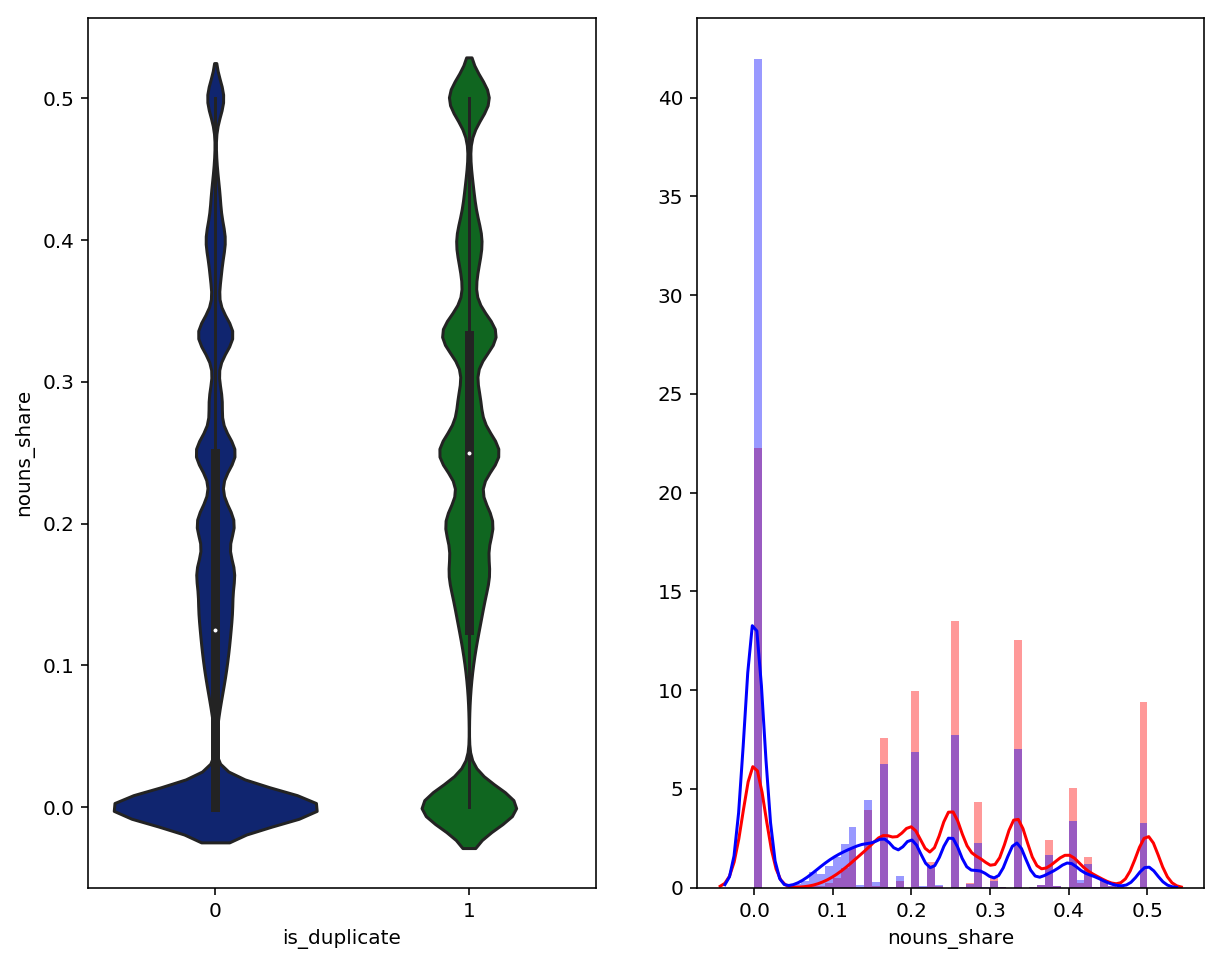

In [35]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'nouns_share', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['nouns_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['nouns_share'][0:] , label = "0" , color = 'blue' )
plt.show()

<h4> 3.5.1.4 Feature: verb_share </h4>

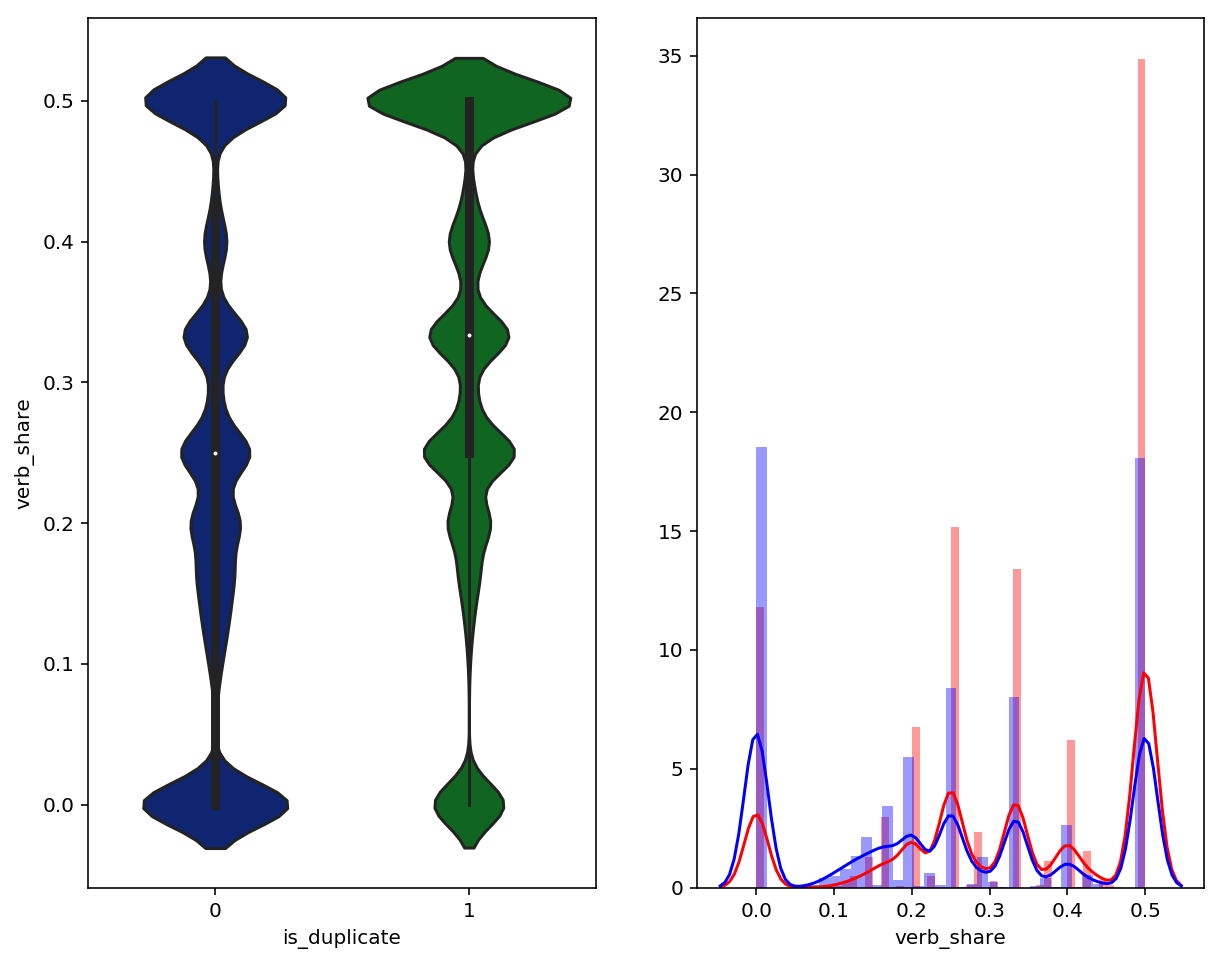

In [36]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'verb_share', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['verb_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['verb_share'][0:] , label = "0" , color = 'blue' )
plt.show()

<h4> 3.5.1.3 Feature: entity_category_share </h4>

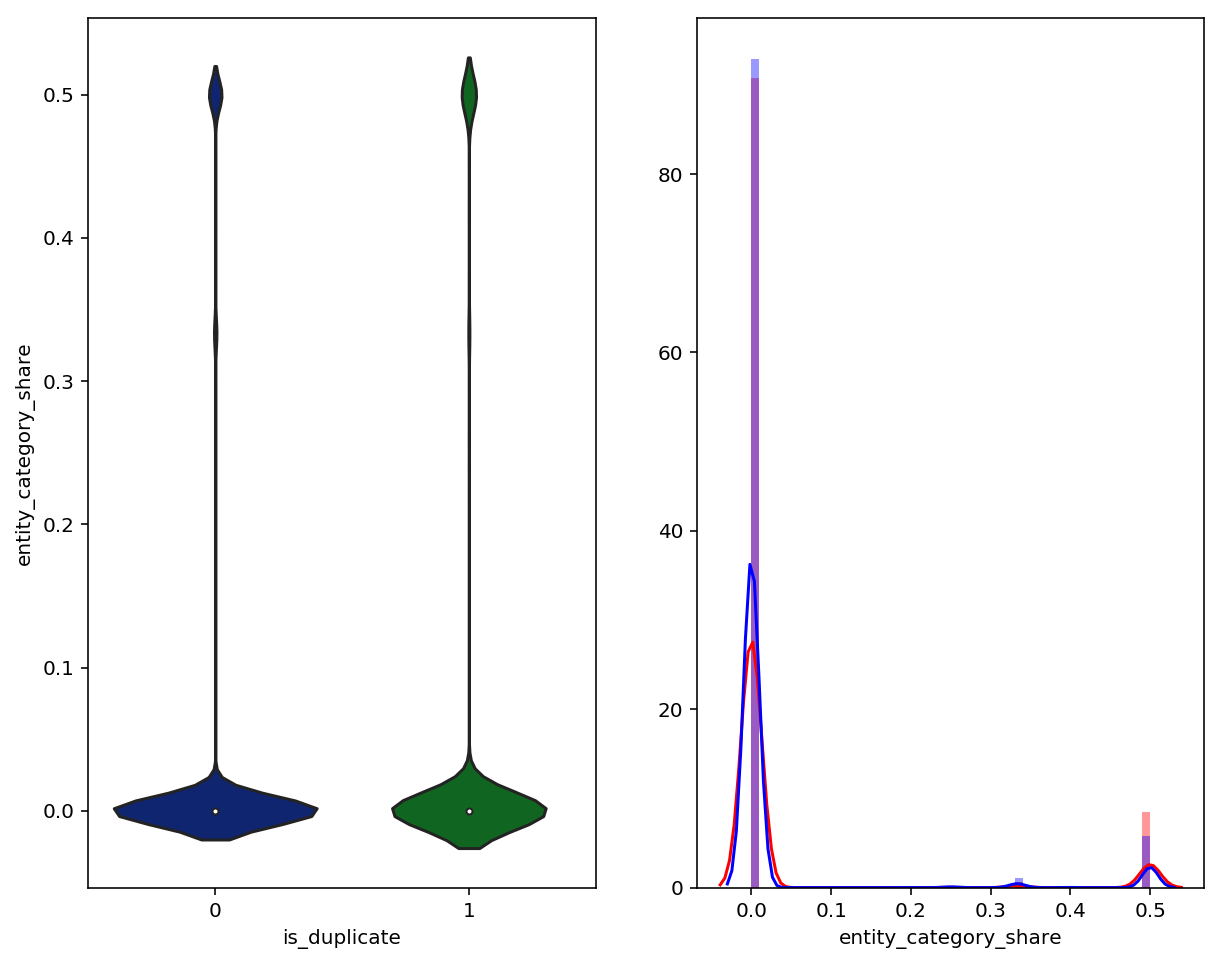

In [37]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'entity_category_share', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['entity_category_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['entity_category_share'][0:] , label = "0" , color = 'blue' )
plt.show()

<h3>3.5.2 Visualization </h3>

In [38]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention

from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [39]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.025s...
[t-SNE] Computed neighbors for 5000 samples in 0.360s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.130446
[t-SNE] Computed conditional probabilities in 0.370s
[t-SNE] Iteration 50: error = 81.2911148, gradient norm = 0.0457501 (50 iterations in 2.611s)
[t-SNE] Iteration 100: error = 70.6044159, gradient norm = 0.0086692 (50 iterations in 1.727s)
[t-SNE] Iteration 150: error = 68.9124908, gradient norm = 0.0056016 (50 iterations in 1.677s)
[t-SNE] Iteration 200: error = 68.1010742, gradient norm = 0.0047585 (50 iterations in 1.739s)
[t-SNE] Iteration 250: error = 67.5907974, gradient norm = 0.0033576

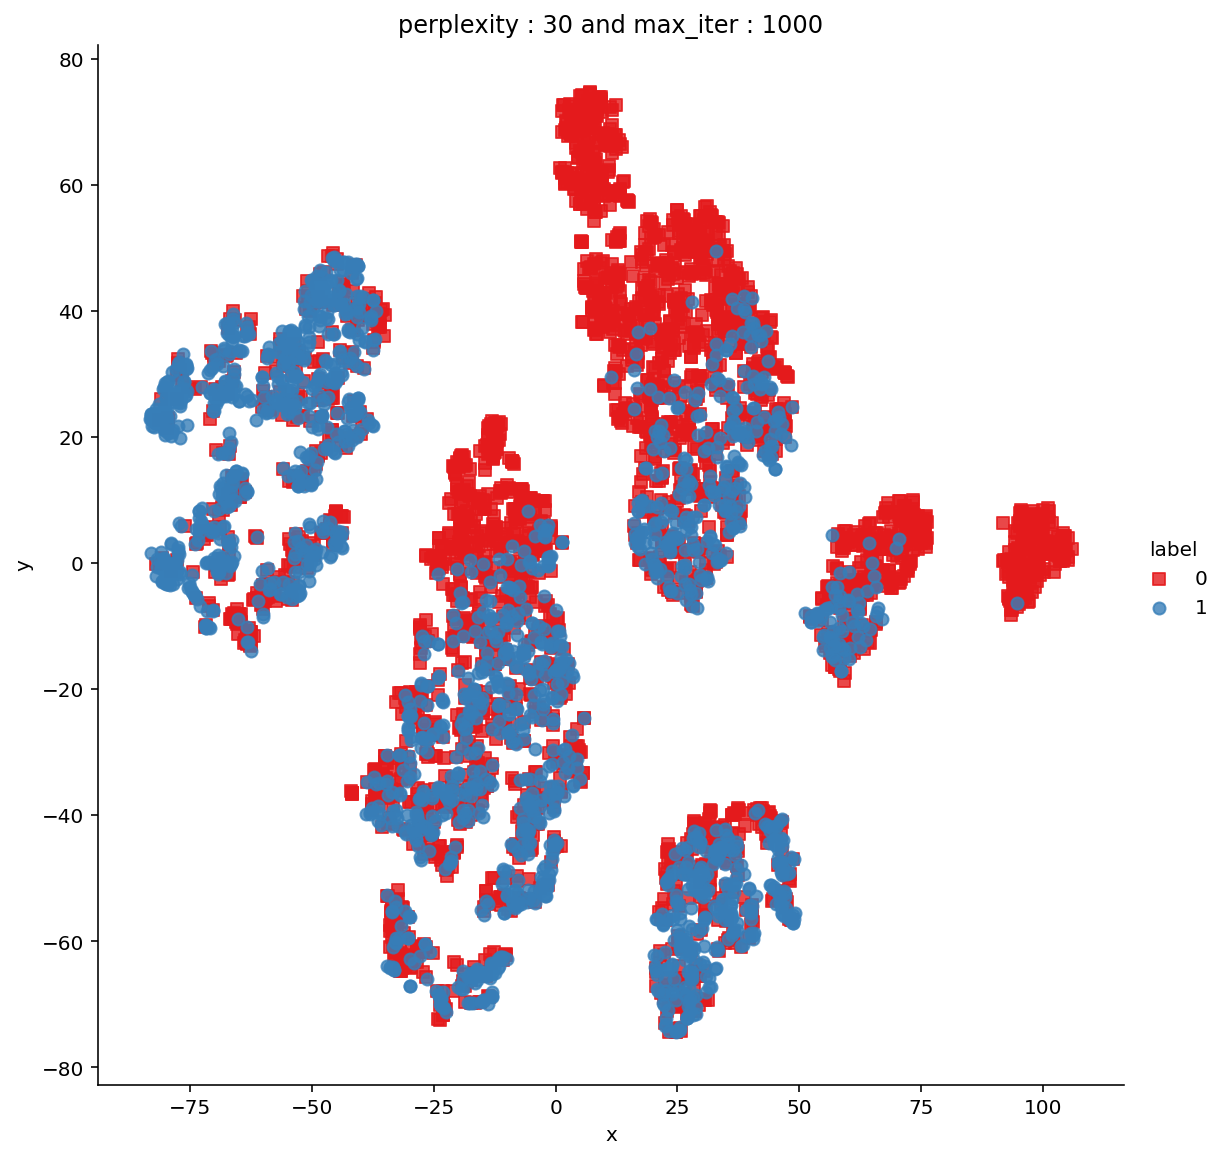

In [40]:
df_tsne = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df_tsne, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [41]:
del tsne2d
del X
del y
del df_tsne

<h2> 3.6 Featurizing text data with tfidf </h2>

<h4>Selecting only 100k data points for the model due to memory constraints.</h4>

In [42]:
min_df = df.sample(n=100000)
print("Minimized DataFrame shape that we will be working on => ", min_df.shape)

min_df['question1'] = min_df['question1'].apply(lambda x: str(x))
min_df['question2'] = min_df['question2'].apply(lambda x: str(x))

min_df['Questions1+2'] = min_df['question1'] + min_df['question2']
y = min_df['is_duplicate']
X = min_df.drop(['is_duplicate'], axis=1)

Minimized DataFrame shape that we will be working on =>  (100000, 40)


<h4>Splitting the 100k dataset into train:test with 70:30 ratio</h4>

In [43]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y, shuffle=True)
x_train_id = x_train['id'].values
x_test_id = x_test['id'].values
y_train = y_train.values
y_test = y_test.values
print("Input  Train Shape: ", x_train.shape)
print("Output Train Shape: ", y_train.shape)
print("Input  Test Shape: ", x_test.shape)
print("Output  Test Shape: ", y_test.shape)

Input  Train Shape:  (70000, 40)
Output Train Shape:  (70000,)
Input  Test Shape:  (30000, 40)
Output  Test Shape:  (30000,)


<h4>Vectorizing the dataset with TFiDF Vectorizer (BiGrams) </h4>

In [44]:
tfidf_model = TfidfVectorizer(min_df=50, ngram_range=(1,2))

tfidf_train = tfidf_model.fit_transform(x_train['Questions1+2'])
w2v_tfidf_train = dict(zip(tfidf_model.get_feature_names(), tfidf_model.idf_))

tfidf_test = tfidf_model.transform(x_test['Questions1+2'])
w2v_tfidf_test = dict(zip(tfidf_model.get_feature_names(), tfidf_model.idf_))

tfidf_train = tfidf_train.todense()
tfidf_test = tfidf_test.todense()

tfidf_train_new = pd.DataFrame(tfidf_train, index=x_train_id)
tfidf_train_new['id'] = x_train['id']
tfidf_test_new = pd.DataFrame(tfidf_test, index=x_test_id)
tfidf_test_new['id'] = x_test['id']

print("TFIDF Train Shape: ", tfidf_train_new.shape)
print("TFIDF Test Shape: ", tfidf_test_new.shape)

TFIDF Train Shape:  (70000, 4207)
TFIDF Test Shape:  (30000, 4207)


In [45]:
x_train_new = x_train.merge(tfidf_train_new, on='id', how='left')
x_test_new = x_test.merge(tfidf_test_new, on='id', how='left')

x_train_new = x_train_new.drop(['id', 'qid1', 'qid2', 'question1', 'question2', 'Questions1+2'], axis=1)
x_test_new = x_test_new.drop(['id', 'qid1', 'qid2', 'question1', 'question2', 'Questions1+2'], axis=1)

print("New Input Train Shape: ", x_train_new.shape)
print("New Input Test Shape: ", x_test_new.shape)

New Input Train Shape:  (70000, 4240)
New Input Test Shape:  (30000, 4240)


<h4>Standardizing the dataset</h4>

In [46]:
std_clf = StandardScaler()

x_train_new = std_clf.fit_transform(x_train_new)
x_test_new = std_clf.transform(x_test_new)

print("New Standardized Input Train Shape: ", x_train_new.shape)
print("New Standardized Input Test Shape: ", x_test_new.shape)

New Standardized Input Train Shape:  (70000, 4240)
New Standardized Input Test Shape:  (30000, 4240)


In [47]:
del tfidf_train
del tfidf_test
del tfidf_train_new
del tfidf_test_new

<h1>4. Machine Learning Models </h1>

In [48]:
global result_report

result_report = pd.DataFrame(columns=['MODEL', 'VECTORIZER', 'DATASET-SIZE', 'LOG-LOSS'])

In [49]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [50]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in Test data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6324571428571428 Class 1:  0.3675428571428571
---------- Distribution of output variable in Test data ----------
Class 0:  0.3675333333333333 Class 1:  0.3675333333333333


<h2> 4.1 Building a random model (Finding worst-case log-loss) </h2>

Log loss on Test Data using Random Model 0.8896935735916057


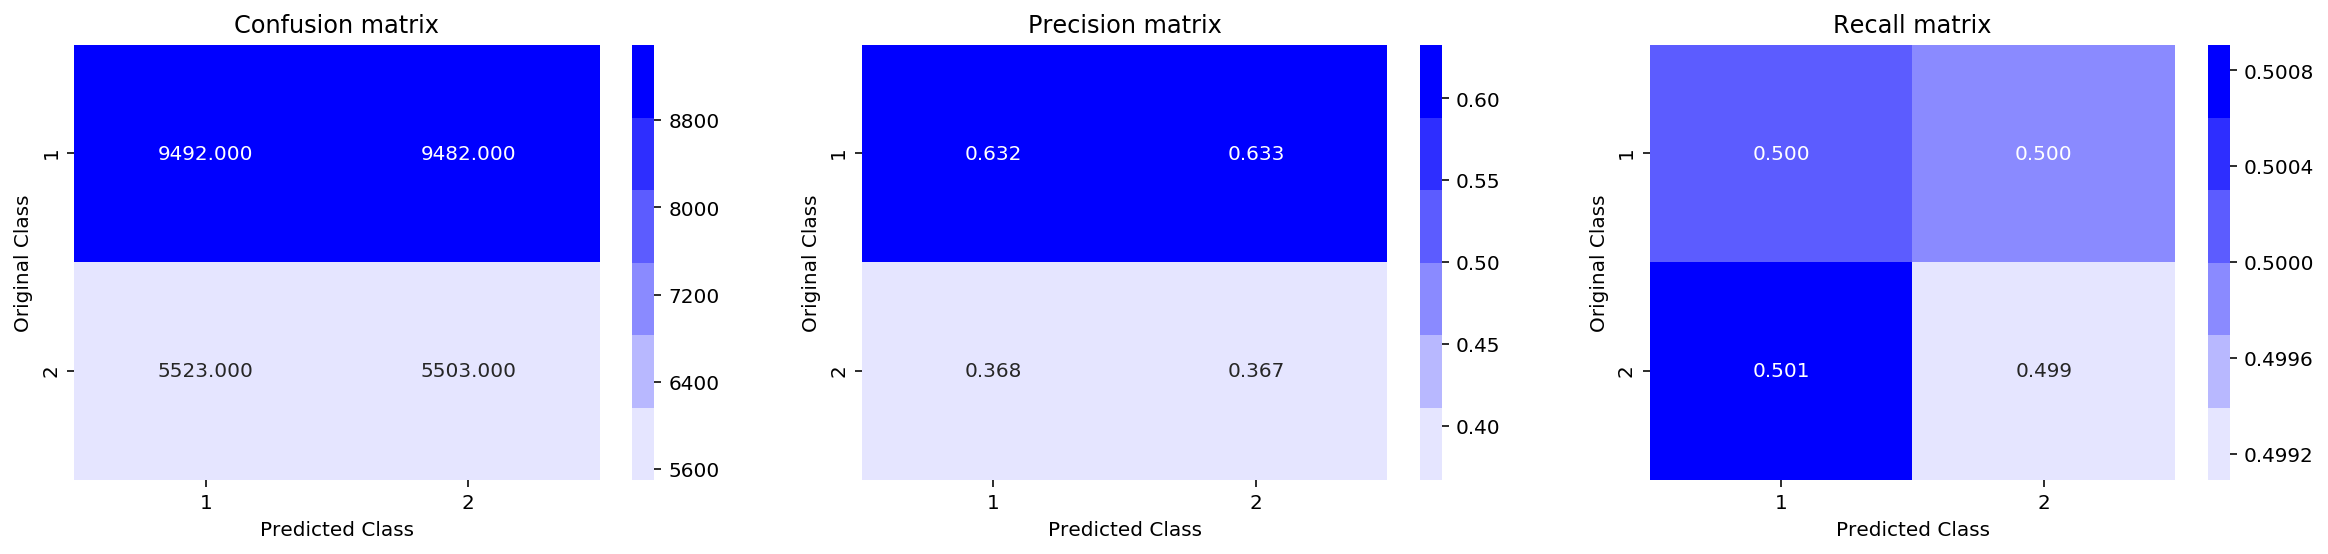

In [51]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

#Saving the report in a global variable
result_report = result_report.append({'MODEL': 'Random Model',
                                        'VECTORIZER': 'TF-IDF',
                                        'DATASET-SIZE': '{0:,.0f}'.format(int(min_df.shape[0])),
                                        'LOG-LOSS':'{:02f}'.format(log_loss(y_test, predicted_y, eps=1e-15))}, ignore_index=True)

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.2 Logistic Regression with hyperparameter tuning </h2>

For values of alpha =  1e-07 The log loss is: 0.4306054353759038
For values of alpha =  1e-06 The log loss is: 0.4256376564497866
For values of alpha =  1e-05 The log loss is: 0.4261096837262898
For values of alpha =  0.0001 The log loss is: 0.40254001928023814
For values of alpha =  0.001 The log loss is: 0.390263093122537
For values of alpha =  0.01 The log loss is: 0.3955734891501438
For values of alpha =  0.1 The log loss is: 0.41092951086543905
For values of alpha =  1 The log loss is: 0.44456235585011383
For values of alpha =  10 The log loss is: 0.47997351587885356
For values of alpha =  100 The log loss is: 0.4911907431085869
For values of alpha =  1000 The log loss is: 0.492583381009083
For values of alpha =  10000 The log loss is: 0.4927336221611308


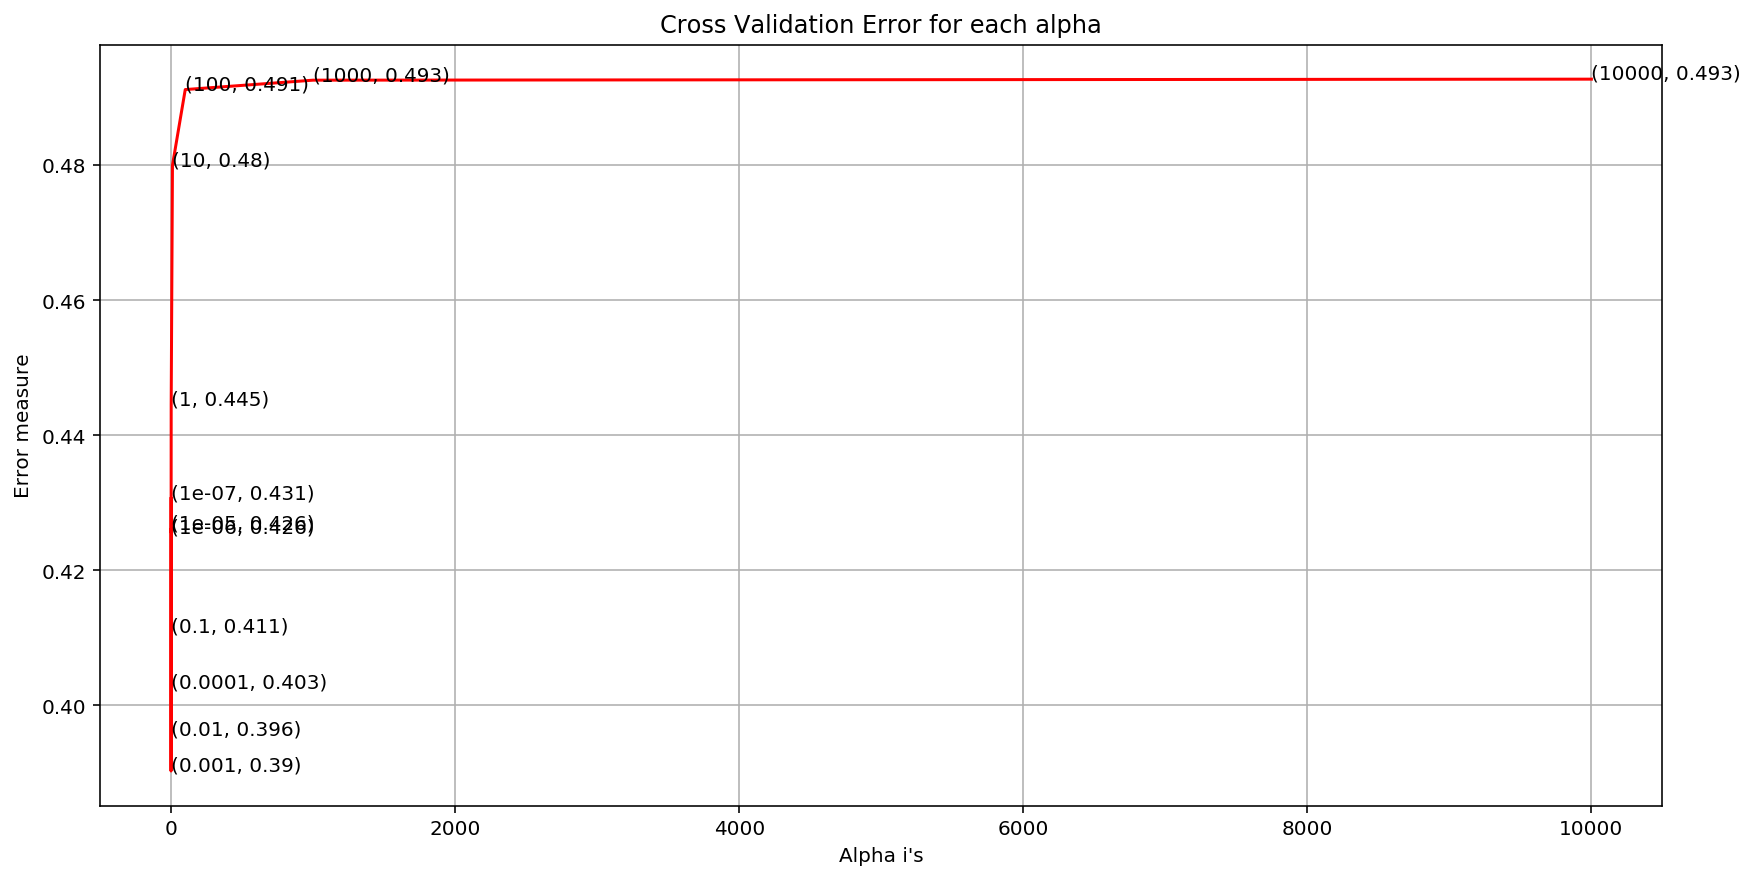

For values of best alpha =  0.001 The train log loss is: 0.34852026543578857
For values of best alpha =  0.001 The test log loss is: 0.390263093122537
Total number of data points : 30000


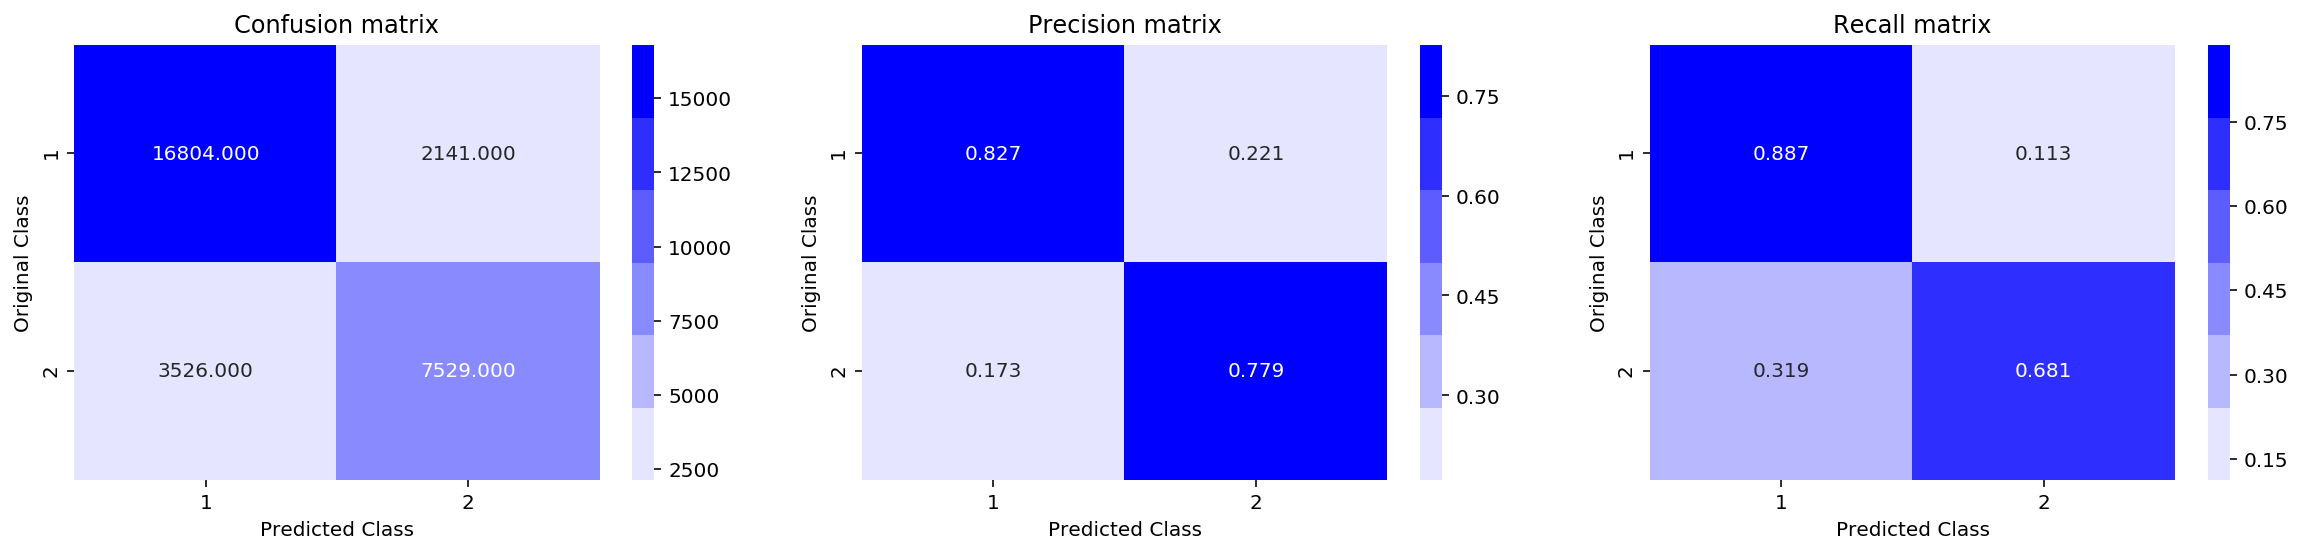

In [52]:
alpha = [10 ** x for x in range(-7, 5)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42, n_jobs=-1)
    clf.fit(x_train_new, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(x_train_new, y_train)
    predict_y = sig_clf.predict_proba(x_test_new)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(alpha, log_error_array,c='r')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42, n_jobs=-1)
clf.fit(x_train_new, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(x_train_new, y_train)

predict_y = sig_clf.predict_proba(x_train_new)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(x_test_new)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

#Saving the report in a global variable
result_report = result_report.append({'MODEL': 'Logistic Regression',
                                        'VECTORIZER': 'TF-IDF',
                                        'DATASET-SIZE': '{0:,.0f}'.format(int(min_df.shape[0])),
                                        'LOG-LOSS':'{:02f}'.format(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))}, ignore_index=True)

<h2> 4.3 Linear SVM with hyperparameter tuning </h2>

For values of alpha =  1e-07 The log loss is: 0.6581525265254936
For values of alpha =  1e-06 The log loss is: 0.6195619796762851
For values of alpha =  1e-05 The log loss is: 0.5175135254741754
For values of alpha =  0.0001 The log loss is: 0.4311138440919082
For values of alpha =  0.001 The log loss is: 0.4588791367227667
For values of alpha =  0.01 The log loss is: 0.6422221813612021
For values of alpha =  0.1 The log loss is: 0.6579038935510204
For values of alpha =  1 The log loss is: 0.6581172465210531
For values of alpha =  10 The log loss is: 0.6580390718317954
For values of alpha =  100 The log loss is: 0.6581525269442107
For values of alpha =  1000 The log loss is: 0.6581525269442108
For values of alpha =  10000 The log loss is: 0.6581525269442109


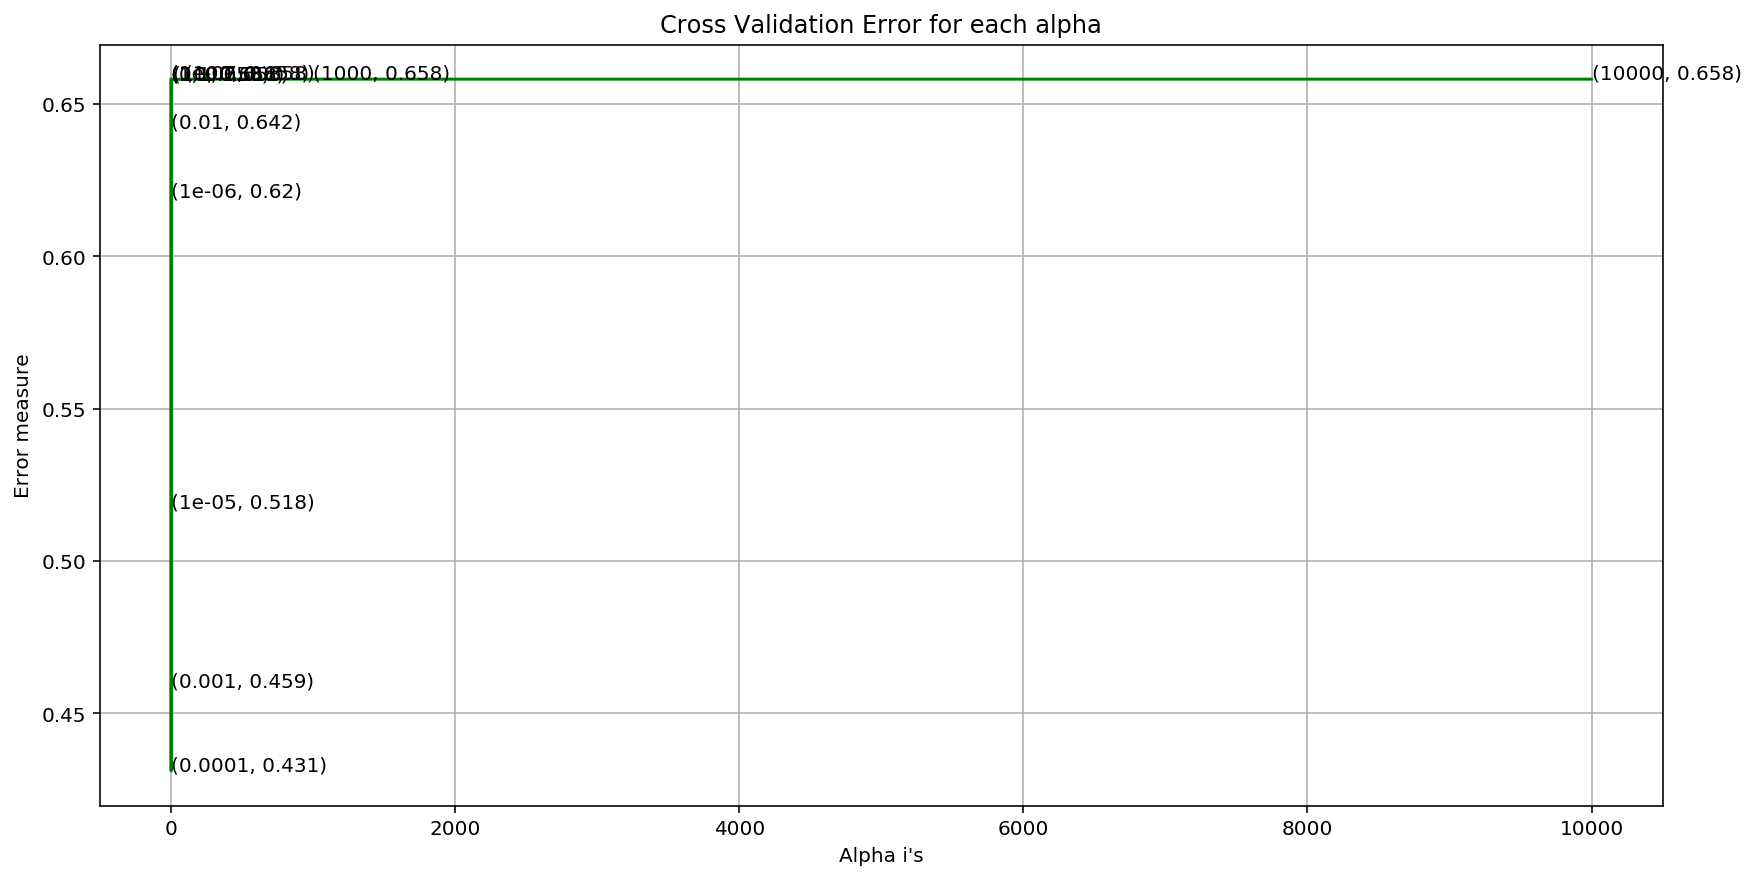

For values of best alpha =  0.0001 The train log loss is: 0.40117134097193546
For values of best alpha =  0.0001 The test log loss is: 0.4311138440919082
Total number of data points : 30000


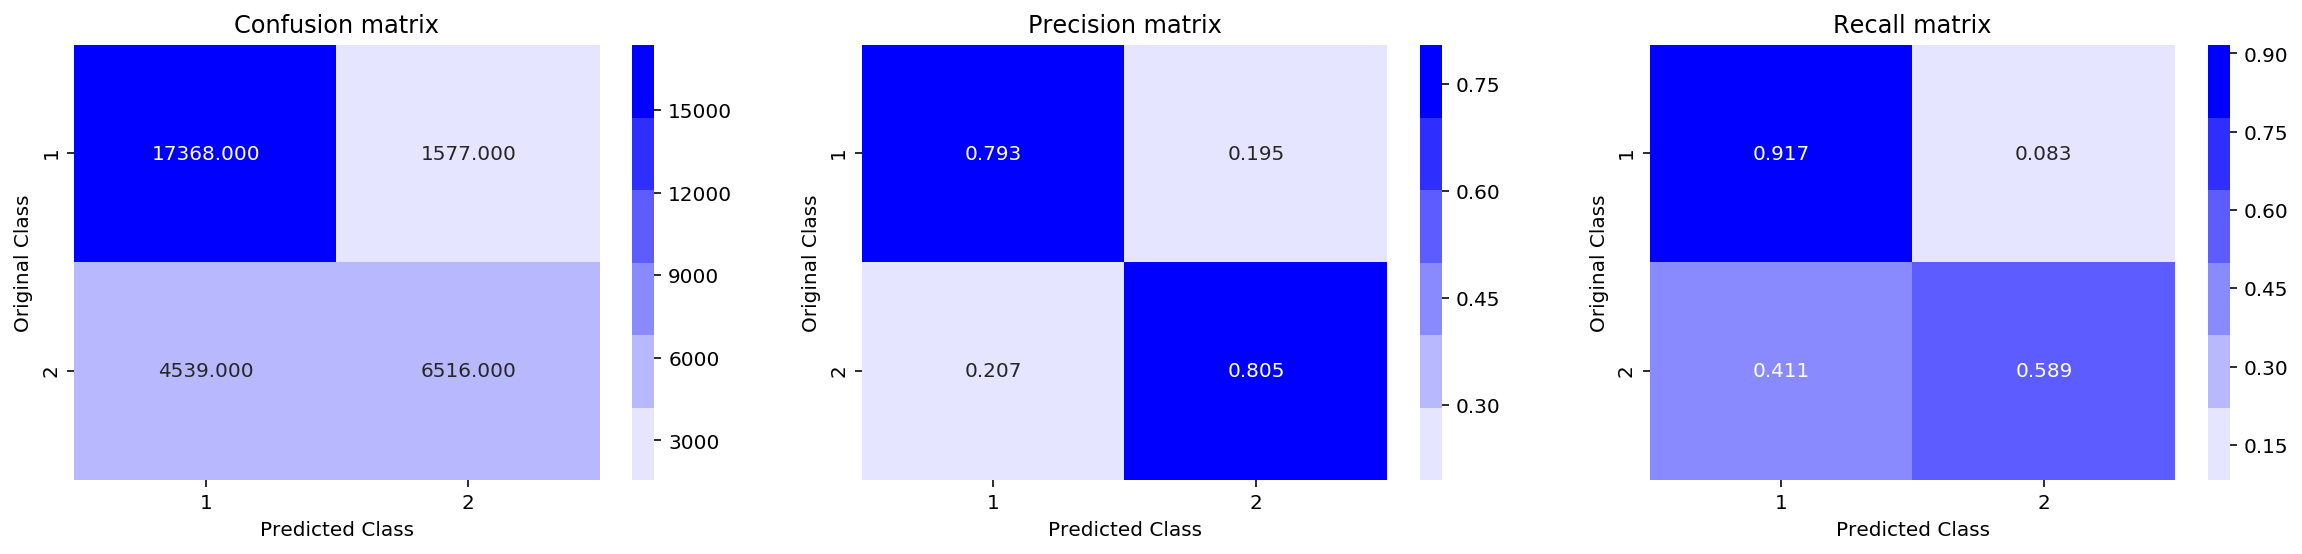

In [53]:
alpha = [10 ** x for x in range(-7, 5)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42, n_jobs=-1)
    clf.fit(x_train_new, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(x_train_new, y_train)
    predict_y = sig_clf.predict_proba(x_test_new)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42, n_jobs=-1)
clf.fit(x_train_new, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(x_train_new, y_train)

predict_y = sig_clf.predict_proba(x_train_new)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(x_test_new)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

#Saving the report in a global variable
result_report = result_report.append({'MODEL': 'Linear SVM',
                                        'VECTORIZER': 'TF-IDF',
                                        'DATASET-SIZE': '{0:,.0f}'.format(int(min_df.shape[0])),
                                        'LOG-LOSS':'{:02f}'.format(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))}, ignore_index=True)

<h2> 4.4 XGBoost </h2>

In [54]:
def spacy_w2v(p_input_question, w2v_tfidf):

    # en_vectors_web_lg, which includes over 1 million unique vectors.
    nlp = spacy.load('en_core_web_sm')

    vecs1 = []
    # https://github.com/noamraph/tqdm
    for qu1 in tqdm(p_input_question):
        doc1 = nlp(qu1) 
        mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
        for word1 in doc1:
            # word2vec
            vec1 = word1.vector
            # fetch df score
            try:
                idf = w2v_tfidf[str(word1)]
            except:
                idf = 0
            # compute final vec
            mean_vec1 += vec1 * idf
        mean_vec1 = mean_vec1.mean(axis=0)
        vecs1.append(mean_vec1)
    return vecs1

In [57]:
x_train_new = x_train.drop(['id', 'qid1', 'qid2', 'question1', 'question2', 'Questions1+2'], axis=1)
x_test_new = x_test.drop(['id', 'qid1', 'qid2', 'question1', 'question2', 'Questions1+2'], axis=1)

train_quest_tfidfw2v = spacy_w2v(x_train['Questions1+2'], w2v_tfidf_train)
test_quest_tfidfw2v = spacy_w2v(x_test['Questions1+2'], w2v_tfidf_test)

x_train_vect = hstack([train_quest_tfidfw2v, x_train_new])
x_test_vect = hstack([test_quest_tfidfw2v, x_test_new])

std_clf = StandardScaler(with_mean=False)
x_train_std = std_clf.fit_transform(x_train_vect)
x_test_std = std_clf.transform(x_test_vect)

100%|██████████| 30000/30000 [05:38<00:00, 83.72it/s]


In [58]:
params = {
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.5, 1],
    'min_child_weight': [2, 4, 6, 8, 10],
    'max_depth': [i for i in range(2, 8, 2)],
    'gamma':[i/10.0 for i in range(0,5)],
    'n_estimators': [50, 100, 250],
    'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}

xgbModel = XGBClassifier(objective='binary:logistic', random_state=42, n_jobs=-1)

randomSearchClf = RandomizedSearchCV(estimator=xgbModel, 
                                     param_distributions=params, 
                                     scoring='neg_log_loss', 
                                     cv=10,
                                     n_jobs=-1,
                                     verbose=10,
                                    return_train_score=True)

randomSearchClf.fit(x_train_std, y_train)

predict_y_train = randomSearchClf.predict_proba(x_train_std)
predict_y = randomSearchClf.predict_proba(x_test_std)
print("The train log loss is:",log_loss(y_train, predict_y_train, eps=1e-15))
print("The test log loss is:",log_loss(y_test, predict_y, eps=1e-15))

#Saving the report in a global variable
result_report = result_report.append({'MODEL': 'XGBoost',
                                        'VECTORIZER': 'TF-IDF W2V',
                                        'DATASET-SIZE': '{0:,.0f}'.format(int(min_df.shape[0])),
                                        'LOG-LOSS':'{:02f}'.format(log_loss(y_test, predict_y, eps=1e-15))}, ignore_index=True)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 17.7min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 20.9min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 23.3min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 32.2min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 40.9min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 44.4min remaining:  1.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 46.4min finished


The train log loss is: 0.3031415999679714
The test log loss is: 0.3346941319970518


In [59]:
randomSearchClf.best_params_

{'gamma': 0.1,
 'learning_rate': 0.1,
 'max_depth': 4,
 'min_child_weight': 2,
 'n_estimators': 250,
 'reg_alpha': 0.001}

Total number of data points : 30000


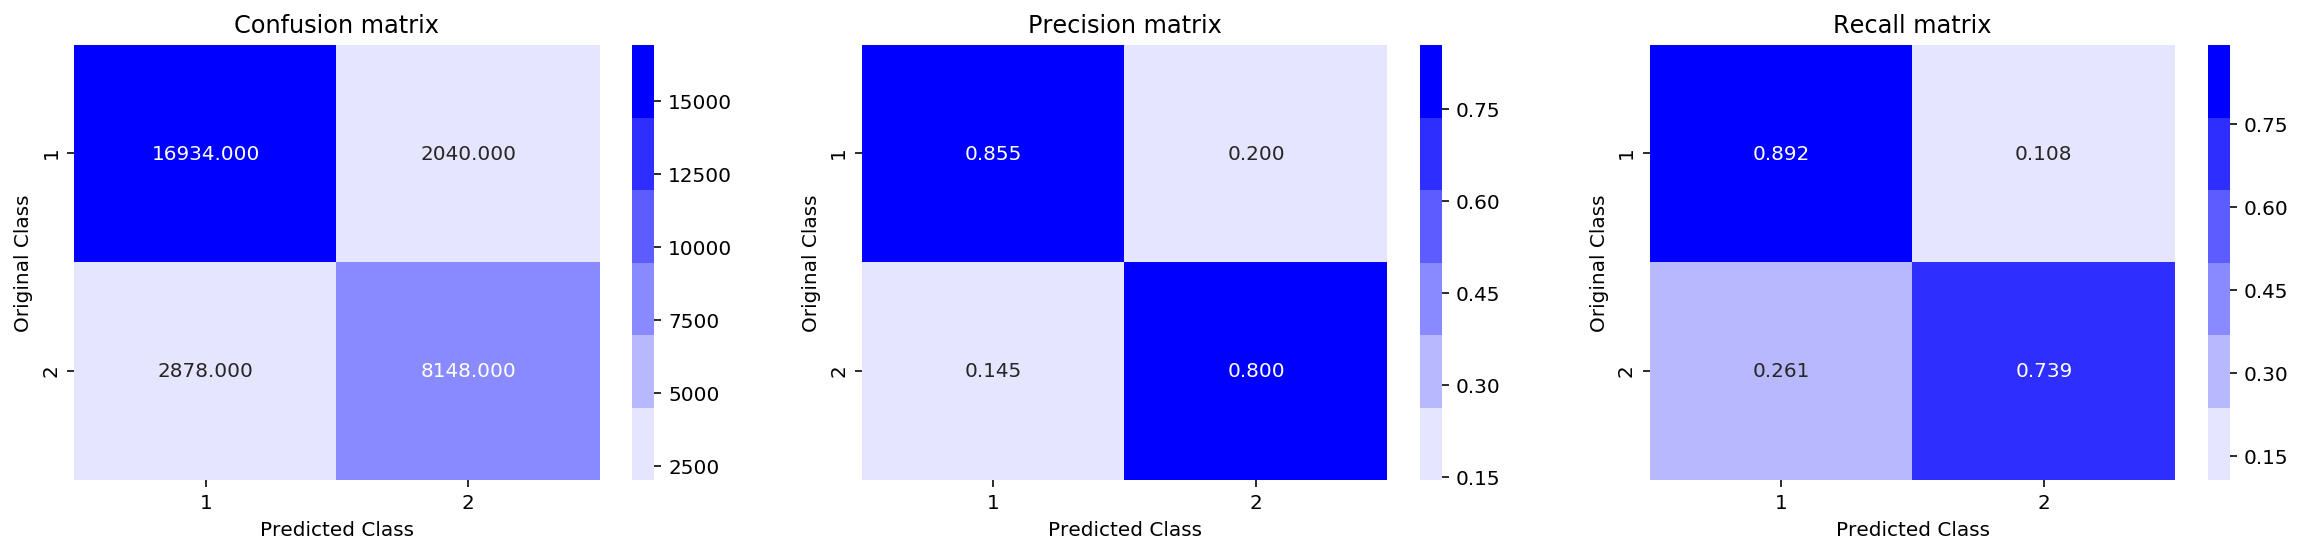

In [60]:
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2>Conclusion</h2>

In [61]:
result_report

,MODEL,VECTORIZER,DATASET-SIZE,LOG-LOSS
0,Random Model,TF-IDF,"100,000",0.889694
1,Logistic Regression,TF-IDF,"100,000",0.390263
2,Linear SVM,TF-IDF,"100,000",0.431114
3,XGBoost,TF-IDF W2V,"100,000",0.334694


<h3> Summarize </h3>

This is a __Binary Classification__ problem where we had to conclude if given two questions are duplicate or not that is, 1 or 0. 
The dataset contains __0.4M__ records. Size of the dataset is around 60MB in .csv file.

The performance metric which I tried to assess is __Log loss, aka logistic loss or cross-entropy loss__.

This is the loss function used in (multinomial) logistic regression and extensions of it such as neural networks, defined as the negative log-likelihood of the true labels given a probabilistic classifier’s predictions. The log loss is only defined for two or more labels. For a single sample with true label yt in {0,1} and estimated probability yp that yt = 1, the log loss is
-log P(yt|yp) = -(yt log(yp) + (1 - yt) log(1 - yp))

This dataset is __slightly imbalanced__ with __63%__ data points to be of non-duplicate category.

While assessing the dataset, I found out that there are __2 rows in Question2 column and 1 row in Question1 column which have null/NA/NaN values__. There were plenty of imputation techniques which could be employed here but I tried to make it quick and easy for implementation as there is less number of such rows. I tried to replace the null/NA/NaN with the empty string ‘’.

<br>
<br>

Some basic featurization techniques which were tried are - 
- __freq_qid1__ = Frequency of qid1's
- __freq_qid2__ = Frequency of qid2's
- __q1len__ = Length of q1
- __q2len__ = Length of q2
- __q1_n_words__ = Number of words in Question 1
- __q2_n_words__ = Number of words in Question 2
- __word_Common__ = (Number of common unique words in Question 1 and Question 2)
- __word_Total__ =(Total num of words in Question 1 + Total num of words in Question 2)
- __word_share__ = (word_common)/(word_Total)
- __freq_q1+freq_q2__ = sum total of the frequency of qid1 and qid2
- __freq_q1-freq_q2__ = absolute difference of frequency of qid1 and qid2
- __No_Questions_q1__ = Total number of questions in qid1
- __No_Questions_q2__ = Total number of questions in qid2
- __q1_q2_difference__ = Number of words which are in Question 1 but no in Question 2
- __q2_q1_difference__ = Number of words which are in Question 2 but no in Question 1
- __diff_len__ = Difference in the absolute value of the Length of q1 and q2

<br><br>
Then Advance featurization techniques which were tried are -
- __cwc_min__ : Ratio of common_word_count to min length of the word count of Q1 and Q2 
- __cwc_min__ = common_word_count / (min(len(q1_words), len(q2_words))
- __cwc_max__ : Ratio of common_word_count to max length of the word count of Q1 and Q2 
- __cwc_max__ = common_word_count / (max(len(q1_words), len(q2_words))
- __csc_min__ : Ratio of common_stop_count to min length of stop count of Q1 and Q2 
- __csc_min__ = common_stop_count / (min(len(q1_stops), len(q2_stops))
- __csc_max__ : Ratio of common_stop_count to max length of stop count of Q1 and Q2
- __csc_max__ = common_stop_count / (max(len(q1_stops), len(q2_stops))
- __ctc_min__ : Ratio of common_token_count to min  of the token count of Q1 and Q2
- __ctc_min__ = common_token_count / (min(len(q1_tokens), len(q2_tokens))
- __ctc_max__ : Ratio of common_token_count to max length of the token count of Q1 and Q2
- __ctc_max__ = common_token_count / (max(len(q1_tokens), len(q2_tokens))
- __last_word_eq__ : Check if the First word of both questions is equal or not
- __last_word_eq__ = int(q1_tokens[-1] == q2_tokens[-1])
- __first_word_eq__ : Check if the First word of both questions is equal or not
- __first_word_eq__ = int(q1_tokens[0] == q2_tokens[0])
- __abs_len_diff__ : Abs. length difference
- __abs_len_diff__ = abs(len(q1_tokens) - len(q2_tokens))
- __mean_len__ : Average Token Length of both Questions
- __mean_len__ = (len(q1_tokens) + len(q2_tokens))/2
- __fuzz_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
- __fuzz_partial_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
- __longest_substr_ratio__ : Ratio of length longest common substring to min length of the token count of Q1 and Q2
- __longest_substr_ratio__ = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))

<br>

__Semantic Featurization__ techniques were also tried where I tried to use Spacy Model and found out the nouns, verbs and entities from the questions and tried to normalize it.
- __nouns_share__ : Extracting parts-of-speech using Spacy model from Questions. Normalized Nouns share between Q1 and Q2
- __verb_share__ : Extracting parts-of-speech using Spacy model from Questions. Normalized Verbs share between Q1 and Q2
- __entity_category_share__ : Extracting parts-of-speech using Spacy model from Questions. Normalized Entity Categorization share between Q1 and Q2
<br>
Exploratory Data Analysis (EDA) was applied to the dataset to visualize the dataset in 2D whether each feature is contributing to the response or not.
I also tried to use T-SNE (t-Distributed Stochastic Neighborhood embedding) to visualize the features/data points in 2D.

Now,
- For featurization, I used __TF-IDF (Term Frequency-Inverse Document Frequency)__ vectorization to vectorize the Questions(Question1 and Question2).
- Splitting the dataset into __70-30__ ratio, I had enough data points (70k) for training my models.
- __Standardization__ of the dataset was done.

Machine learning models that were tried (in the given order) -
- __Random model__
- __Logistic Regression (Ridge Regression with Alpha as Hyperparameter)__
- __Linear SVM (Lasso Regression and Alpha as Hyperparameter)__

For Boosting, I used TF-IDF Weighted W2vV using Glove spacy model.
- __XGBoost (RandomizedSearch CV with hyperparameter tuning)__

For Extreme Gradient Boosting (XGBoost), I performed a RandomizedSearch cross-validation technique in order to control overfitting-underfitting problem. Also, there were a variety of hyperparameters which I tried __max_depth, gamma, n_estimators, reg_alpha, learning_rate, min_child_weight__.

<h2>In conclusion, on reviewing the result which each model gives, I found out that Gradient Boosting (XGBoost) performs much better with 0.33 as log loss. <h2>